In [128]:
import os
import io
import sys
import json
import boto3
import pymongo 
import numpy as np
import pandas as pd
import seaborn as sns

from tqdm import tqdm
from matplotlib import cm
import matplotlib.pyplot as plt
import matplotlib.patches as patches

from PIL import Image
from collections import Counter

sys.path.append("../")
import cabutils

In [129]:
sns.set_style("whitegrid")
sns.set_context("talk")

from matplotlib import rcParams
rcParams["font.size"] = 18
rcParams["figure.titlesize"] = 26

In [130]:
projName = "mlve"
experiment = "nsd"
experimentName = f"{experiment}-surface-normals"
S3_BUCKET_NAME = "mlve-v1"

attention_check = "attentionCheck"
batch_idx = "batchIdx"

In [131]:
conn = cabutils.get_db_connection()
db = conn[projName + "_outputs"]

Checking database connection...


ServerSelectionTimeoutError: localhost:8899: [Errno 61] Connection refused, Timeout: 5.0s, Topology Description: <TopologyDescription id: 6464ff1260a8ba6c209e4015, topology_type: Unknown, servers: [<ServerDescription ('localhost', 8899) server_type: Unknown, rtt: None, error=AutoReconnect('localhost:8899: [Errno 61] Connection refused')>]>

In [ ]:
names = list(db.list_collection_names())
names.sort()

In [ ]:
for name in names:
    print(name)

gestalt_object-loc
gestalt_shapegen-depth-estimation-pilot
gestalt_shapegen-depth-estimation-split-half
gestalt_shapegen-segmentation-split-half
gestalt_shapegen-surface-normals
gestalt_shapegen-surface-normals-split-half
gestalt_shapegen_object-loc
gestalt_shapegen_video-object-loc
gestalt_video-object-loc
hypersim_surface-normals
hypersim_surface-normals-splithalf
hypersim_v2-depth-estimation-pilot
hypersim_v3-depth-estimation-split-half
hypersim_v3-segmentation-split-half
hypersim_v3-surface-normals
nsd-depth-estimation-pilot
nsd-object-loc-split-half
nsd-segmentation
nsd-surface-normals
nsd_surface-normals
tdw-depth-estimation-pilot
tdw-depth-estimation-split-half
tdw-segmentation
tdw-segmentation-split-half
tdw-surface-normals-split-half
tdw_surface-normals


In [ ]:
summaries = {}

In [ ]:
def results_to_df(iterName=None):
        results = []
        cursor = col.find({})
        for document in tqdm(cursor):
            results.append(document)

        df = pd.DataFrame(results)
        return df

In [ ]:
from glob import glob
names = glob("datasets/*")
names = [name.split(".")[0].split("datasets/")[1] for name in names]

In [ ]:
names

['hypersim_surface-normals',
 'gestalt_shapegen-surface-normals',
 'gestalt_shapegen_object-loc',
 'tdw-depth-estimation-pilot',
 'tdw_surface-normals',
 'static_detection_pilot_v1-results',
 'gestalt_object-loc',
 'nsd_surface-normals',
 'hypersim_v3-surface-normals',
 'hypersim_v2-depth-estimation-pilot',
 'tdw-segmentation-split-half',
 'tdw-surface-normals-split-half',
 'gestalt_shapegen_video-object-loc',
 'gestalt_shapegen-segmentation-split-half',
 'tdw-depth-estimation-split-half',
 'nsd-surface-normals',
 'tdw-segmentation',
 'nsd-segmentation',
 'tom_m2s_shapenet13',
 'hypersim_surface-normals-splithalf',
 'tom_m2s_shapenet13',
 'tom_m2s_shapenet13',
 'nsd-depth-estimation-pilot',
 'gestalt_shapegen-depth-estimation-pilot',
 'tom_m2s_shapenet13',
 'hypersim_v3-depth-estimation-split-half',
 'nsd-object-loc-split-half',
 'gestalt_shapegen-surface-normals-split-half',
 'hypersim_v3-segmentation-split-half',
 'gestalt_video-object-loc',
 'gestalt_shapegen-depth-estimation-split-

In [ ]:
db = None

In [132]:
for col_name in tqdm(names):
    if "depth" not in col_name and "surface" not in col_name and "segmentation" not in col_name:
        continue
    summaries[col_name] = {}
    print("Getting summary data for ", col_name)
    
    if os.path.exists(f"datasets/{col_name}.csv"):
        df = pd.read_csv(f"datasets/{col_name}.csv")
    else:
        col = db[col_name]
        df = results_to_df() # drop non-experiment trials
        df.to_csv(f"datasets/{col_name}.csv")
    
    get_trial_key = lambda x: [key for key in x if "batch" in key][0]
    
    total_records = len(df)
    n_participants = len(df["userID"].dropna().unique())
    iteration_names = df["iterationName"].unique()

    get_batch_key = lambda x: [key for key in x if "batch" in key][0]
    batch_key = get_batch_key(df.columns)
    n_batches = len(df[batch_key].dropna().unique())
    
    print(f"Total Records: {total_records}, n_participants: {n_participants}, n_points: {n_batches}, iterations: {len(iteration_names)}")
    
    summaries[col_name]["n_participants"] = n_participants
    summaries[col_name]["n_points"] = n_batches
    summaries[col_name]["total_records"] = total_records
    summaries[col_name]["n_iterations"] = len(iteration_names)
    summaries[col_name]["iteration_names"] = iteration_names
    

 12%|█▏        | 3/26 [00:00<00:00, 29.26it/s]

Getting summary data for  gestalt_shapegen-depth-estimation-pilot
Total Records: 5098, n_participants: 39, n_points: 10, iterations: 1
Getting summary data for  gestalt_shapegen-depth-estimation-split-half
Total Records: 4115, n_participants: 31, n_points: 1, iterations: 1
Getting summary data for  gestalt_shapegen-segmentation-split-half
Total Records: 4192, n_participants: 31, n_points: 1, iterations: 1
Getting summary data for  gestalt_shapegen-surface-normals
Total Records: 13827, n_participants: 105, n_points: 11, iterations: 1
Getting summary data for  gestalt_shapegen-surface-normals-split-half


 23%|██▎       | 6/26 [00:01<00:06,  3.04it/s]

Total Records: 4070, n_participants: 35, n_points: 1, iterations: 1
Getting summary data for  hypersim_surface-normals


 38%|███▊      | 10/26 [00:02<00:03,  4.06it/s]

Total Records: 7647, n_participants: 58, n_points: 10, iterations: 2
Getting summary data for  hypersim_surface-normals-splithalf


 42%|████▏     | 11/26 [00:02<00:04,  3.69it/s]

Total Records: 5041, n_participants: 40, n_points: 1, iterations: 1
Getting summary data for  hypersim_v2-depth-estimation-pilot
Total Records: 4039, n_participants: 30, n_points: 10, iterations: 1
Getting summary data for  hypersim_v3-depth-estimation-split-half
Total Records: 4110, n_participants: 30, n_points: 1, iterations: 1
Getting summary data for  hypersim_v3-segmentation-split-half
Total Records: 4216, n_participants: 31, n_points: 1, iterations: 1
Getting summary data for  hypersim_v3-surface-normals


 69%|██████▉   | 18/26 [00:04<00:01,  4.85it/s]

Total Records: 13327, n_participants: 104, n_points: 11, iterations: 1
Getting summary data for  nsd-depth-estimation-pilot
Total Records: 4110, n_participants: 30, n_points: 10, iterations: 1
Getting summary data for  nsd-segmentation
Total Records: 32160, n_participants: 252, n_points: 30, iterations: 1
Getting summary data for  nsd-surface-normals
Total Records: 21948, n_participants: 213, n_points: 31, iterations: 2
Getting summary data for  nsd_surface-normals


 92%|█████████▏| 24/26 [00:06<00:00,  3.93it/s]

Total Records: 4109, n_participants: 32, n_points: 10, iterations: 1
Getting summary data for  tdw-depth-estimation-pilot
Total Records: 4105, n_participants: 30, n_points: 10, iterations: 1
Getting summary data for  tdw-depth-estimation-split-half
Total Records: 4098, n_participants: 30, n_points: 1, iterations: 1
Getting summary data for  tdw-segmentation
Total Records: 3014, n_participants: 22, n_points: 1, iterations: 1
Getting summary data for  tdw-segmentation-split-half
Total Records: 4110, n_participants: 30, n_points: 1, iterations: 1
Getting summary data for  tdw-surface-normals-split-half
Total Records: 4250, n_participants: 33, n_points: 1, iterations: 1
Getting summary data for  tdw_surface-normals


100%|██████████| 26/26 [00:07<00:00,  3.50it/s]

Total Records: 6409, n_participants: 52, n_points: 10, iterations: 2


In [99]:
all_summaries = summaries

summaries = {}
for key in all_summaries:
    if "object-loc" not in key:
        summaries[key] = all_summaries[key]

In [100]:
summary_df = pd.DataFrame(summaries)

In [101]:
summary_df

,gestalt_shapegen-depth-estimation-pilot,gestalt_shapegen-depth-estimation-split-half,gestalt_shapegen-segmentation-split-half,gestalt_shapegen-surface-normals,gestalt_shapegen-surface-normals-split-half,hypersim_surface-normals,hypersim_surface-normals-splithalf,hypersim_v2-depth-estimation-pilot,hypersim_v3-depth-estimation-split-half,hypersim_v3-segmentation-split-half,...,nsd-depth-estimation-pilot,nsd-segmentation,nsd-surface-normals,nsd_surface-normals,tdw-depth-estimation-pilot,tdw-depth-estimation-split-half,tdw-segmentation,tdw-segmentation-split-half,tdw-surface-normals-split-half,tdw_surface-normals
n_participants,39,31,31,105,35,58,40,30,30,31,...,30,252,213,32,30,30,22,30,33,52
n_points,10,1,1,11,1,10,1,10,1,1,...,10,30,31,10,10,1,1,1,1,10
total_records,5098,4115,4192,13827,4070,7647,5041,4039,4110,4216,...,4110,32160,21948,4109,4105,4098,3014,4110,4250,6409
n_iterations,1,1,1,1,1,2,1,1,1,1,...,1,1,2,1,1,1,1,1,1,2
iteration_names,[v1-full],[v1-full],[v1-full],[large-scale-v1],[v1-full],"[v2, 071822_absolute]",[080822-relative],[v1-full],[v1-full],[v1-full],...,[v1-full],[v2-all],"[large-scale-v1, v2-all]",[v2],[v1-full],[v1-full],[large-scale-v1],[v1-full],[v1-full],"[v2, 071822_absolute]"


In [102]:
stat_first = {"n_participants": {}, "n_points": {}, "n_iterations": {}, "total_records": {}, "iteration_names": {}}
for dataset in summaries:
    for stat in summaries[dataset]:
        stat_first[stat][dataset] = summaries[dataset][stat]

In [103]:
stat_df = pd.DataFrame(stat_first)

In [104]:
stat_df.to_csv("stat_df.csv")

In [105]:
stat_df

,n_participants,n_points,n_iterations,total_records,iteration_names
gestalt_shapegen-depth-estimation-pilot,39,10,1,5098,[v1-full]
gestalt_shapegen-depth-estimation-split-half,31,1,1,4115,[v1-full]
gestalt_shapegen-segmentation-split-half,31,1,1,4192,[v1-full]
gestalt_shapegen-surface-normals,105,11,1,13827,[large-scale-v1]
gestalt_shapegen-surface-normals-split-half,35,1,1,4070,[v1-full]
hypersim_surface-normals,58,10,2,7647,"[v2, 071822_absolute]"
hypersim_surface-normals-splithalf,40,1,1,5041,[080822-relative]
hypersim_v2-depth-estimation-pilot,30,10,1,4039,[v1-full]
hypersim_v3-depth-estimation-split-half,30,1,1,4110,[v1-full]
hypersim_v3-segmentation-split-half,31,1,1,4216,[v1-full]


In [106]:
stat_df["n_participants"].sum()

1258

In [107]:
import plotting
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [108]:
def filter_attention_check_fails(df, key="correct", threshold=0.5, remove_failures=True, remove_attention_trials=True):
    att_key = lambda x: [k for k in x if "attention" in k][0]
    attention_key = att_key(df.columns)
    att_checks = df.loc[df[attention_key] == True]
    failed_checks = att_checks.groupby("userID")[key].mean() < threshold
    participants_failed = [failed_checks.keys()[i] for i in range(len(failed_checks)) if failed_checks[i]]
    if remove_failures:
        if len(participants_failed) == 0:
            print("No one failed any attention checks!")
        else:   
            df = df[~df["userID"].isin(participants_failed)]
        
    if remove_attention_trials:
        df = df[df[attention_key] == False]
            
    return df

def str_to_float_array(str_arr):
    if type(str_arr) == list:
        return str_arr
    
    if str_arr == np.nan or str_arr == "nan" or str_arr == float("nan") or not str_arr:
        return []

    arr = []
    str_arr = str_arr.strip("[]").split(",")
    for st in str_arr:
        try:
            arr.append(float(st))
        except:
            return []
    return arr

In [109]:
df = pd.read_csv("stat_df.csv")

gestalt_shapegen-depth-estimation-pilot


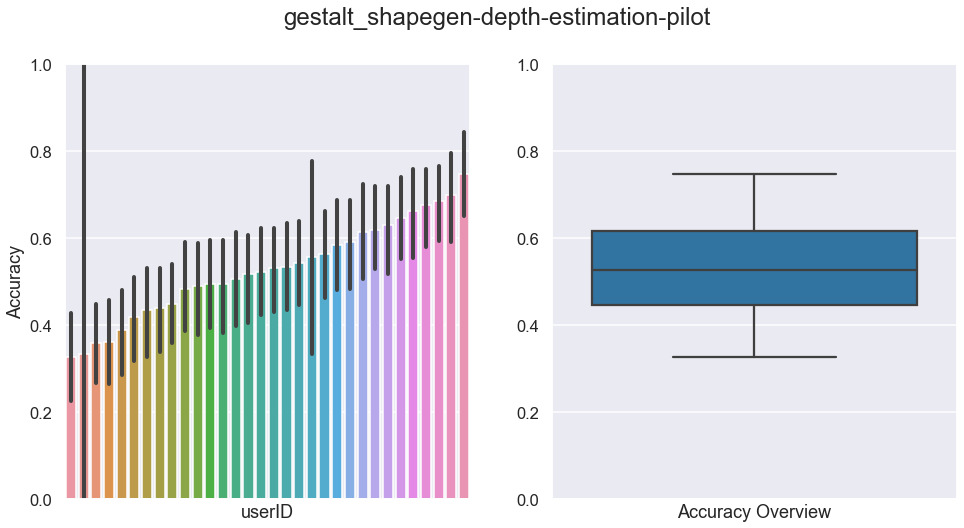

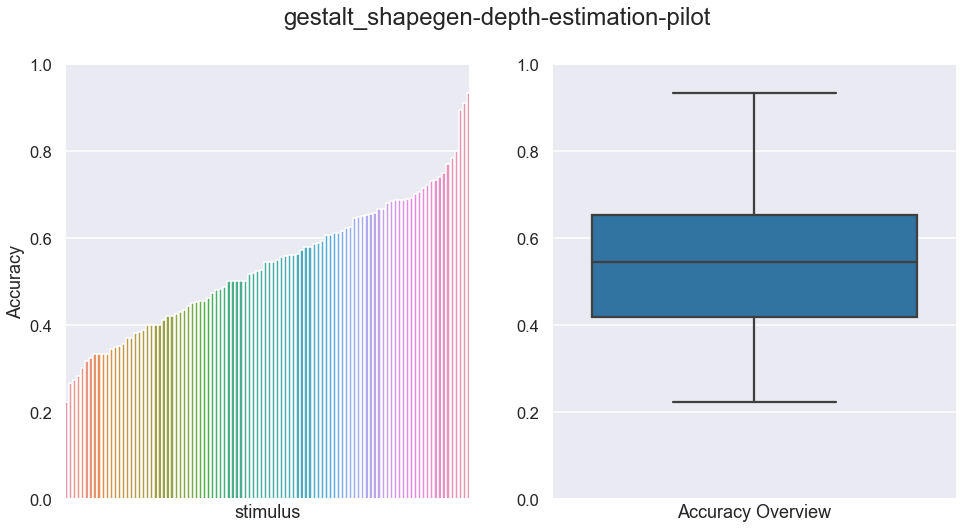

Minimum people per trial: 5
Not enough people to check split half.



gestalt_shapegen-depth-estimation-split-half


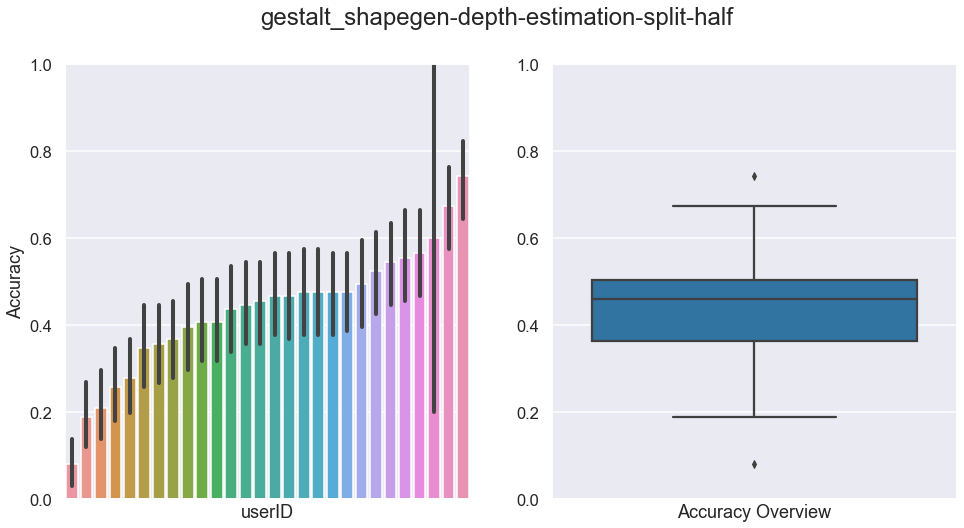

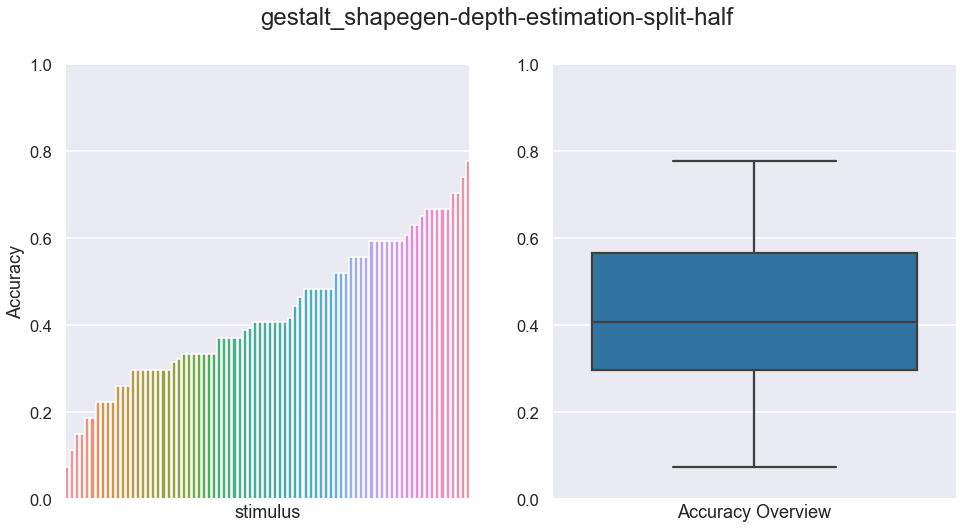

Minimum people per trial: 27
(80, 27) trials to choose from
Subs per split [ 2  3  4  5  6  7  8  9 10 11 12 13]


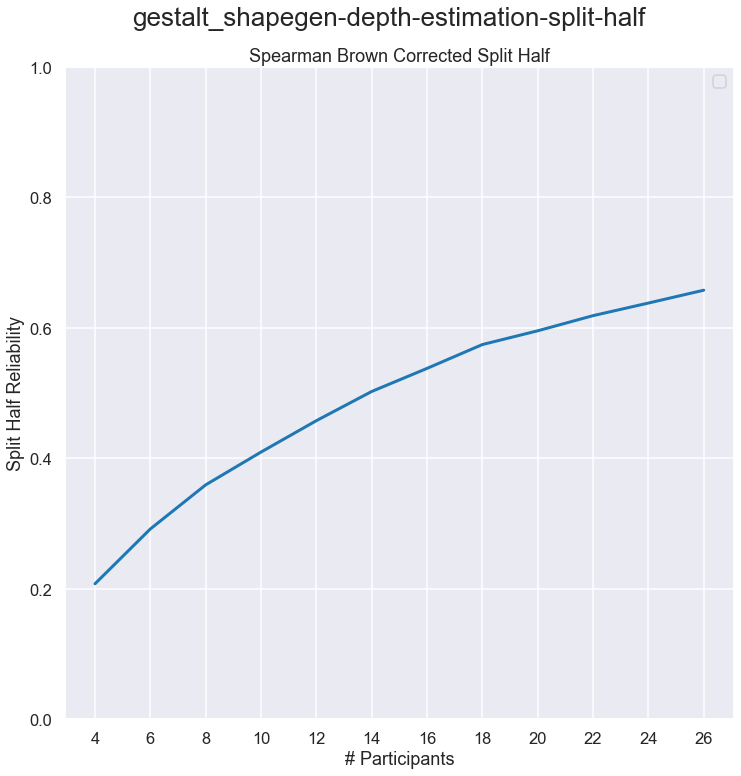




gestalt_shapegen-segmentation-split-half
No one failed any attention checks!


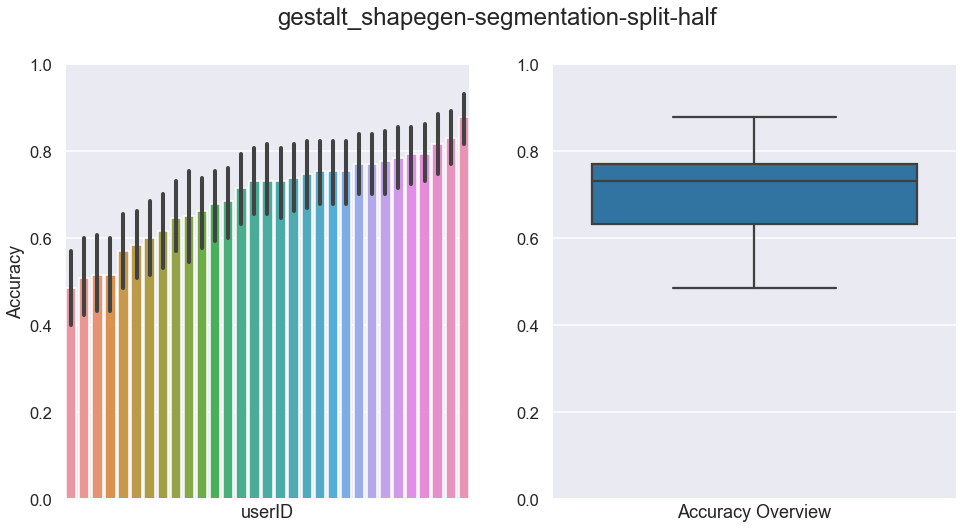

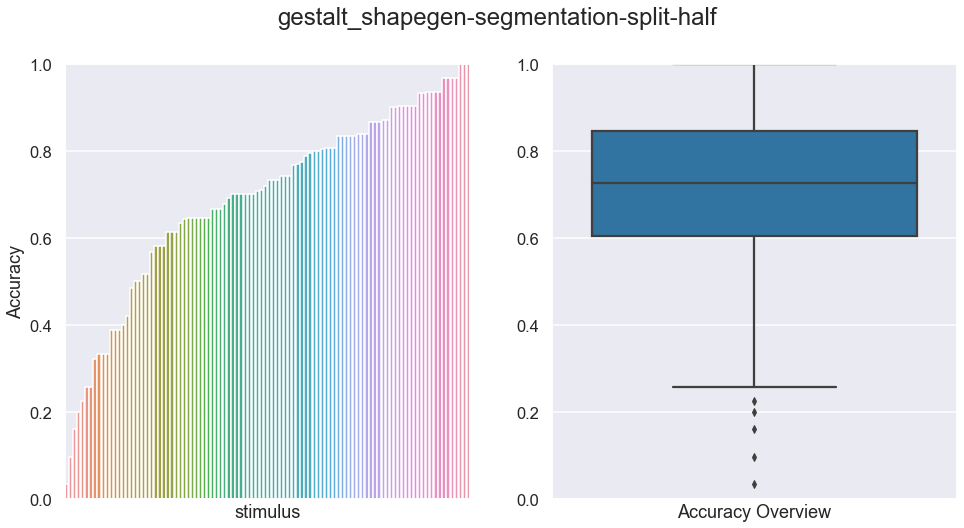

Minimum people per trial: 30
(100, 30) trials to choose from
Subs per split [ 2  3  4  5  6  7  8  9 10 11 12 13 14 15]


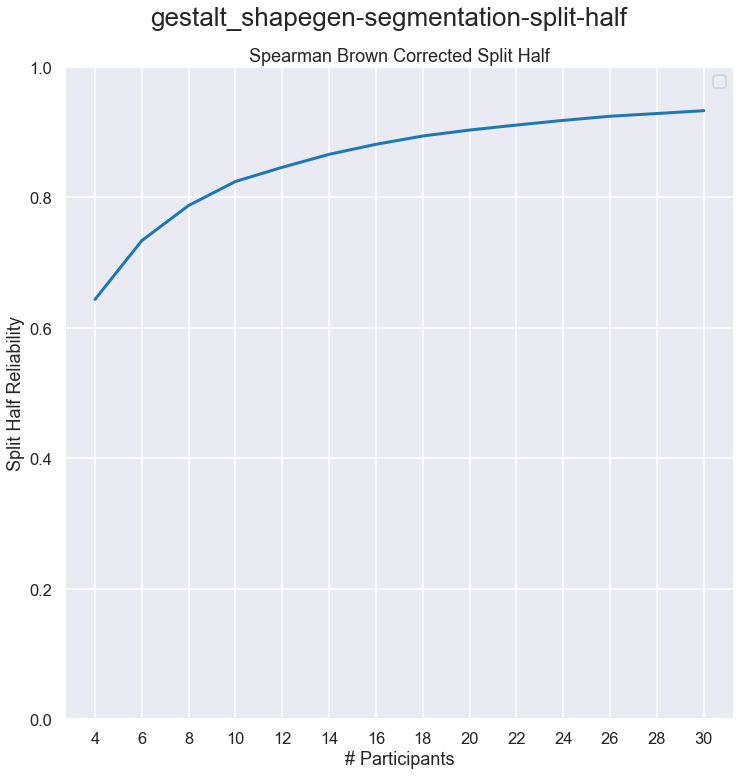




hypersim_v2-depth-estimation-pilot


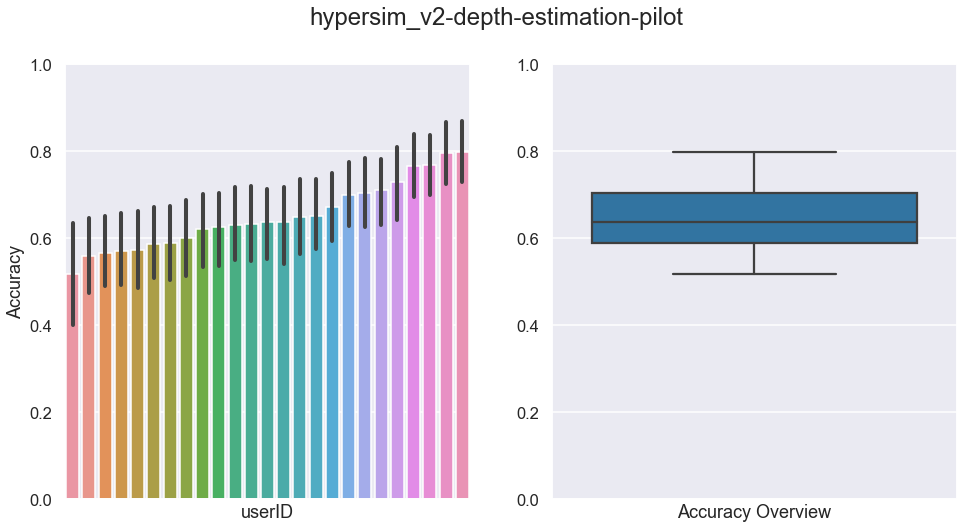

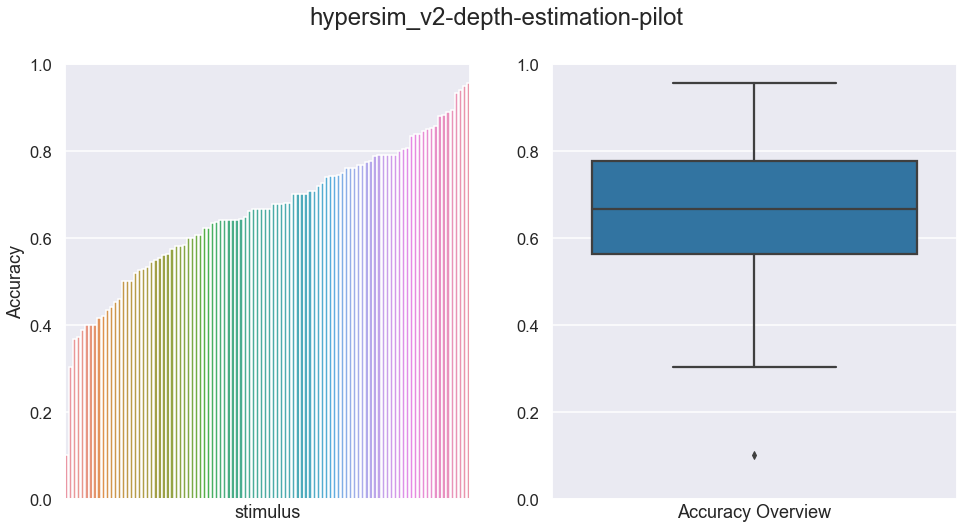

Minimum people per trial: 3
Not enough people to check split half.



hypersim_v3-depth-estimation-split-half
No one failed any attention checks!


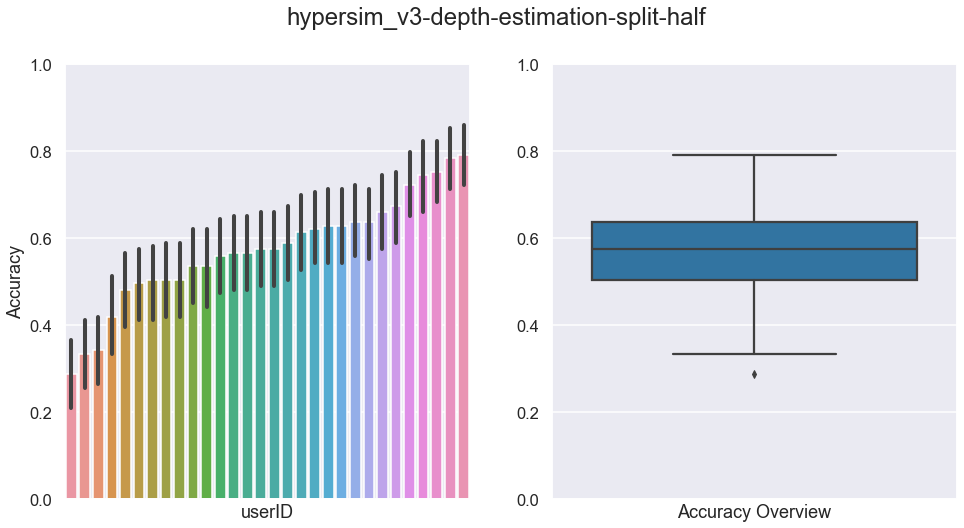

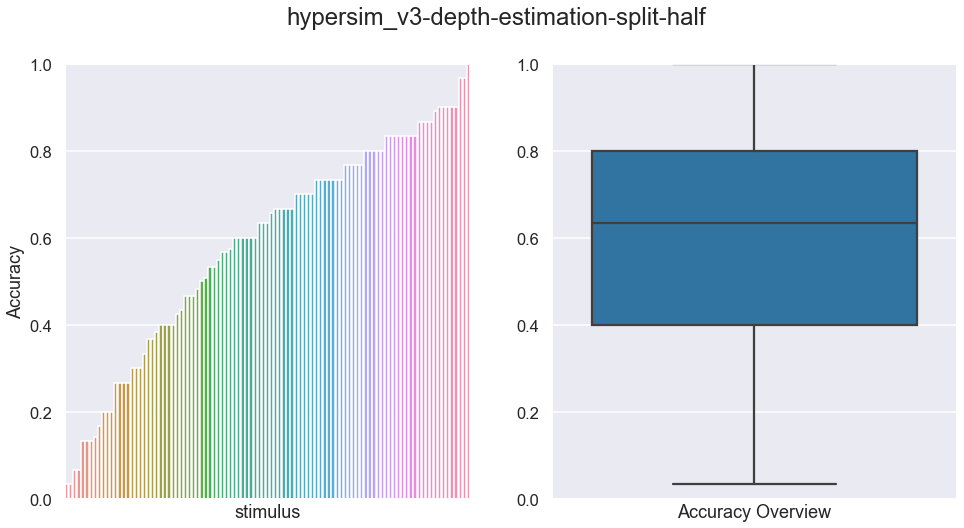

Minimum people per trial: 30
(99, 30) trials to choose from
Subs per split [ 2  3  4  5  6  7  8  9 10 11 12 13 14 15]


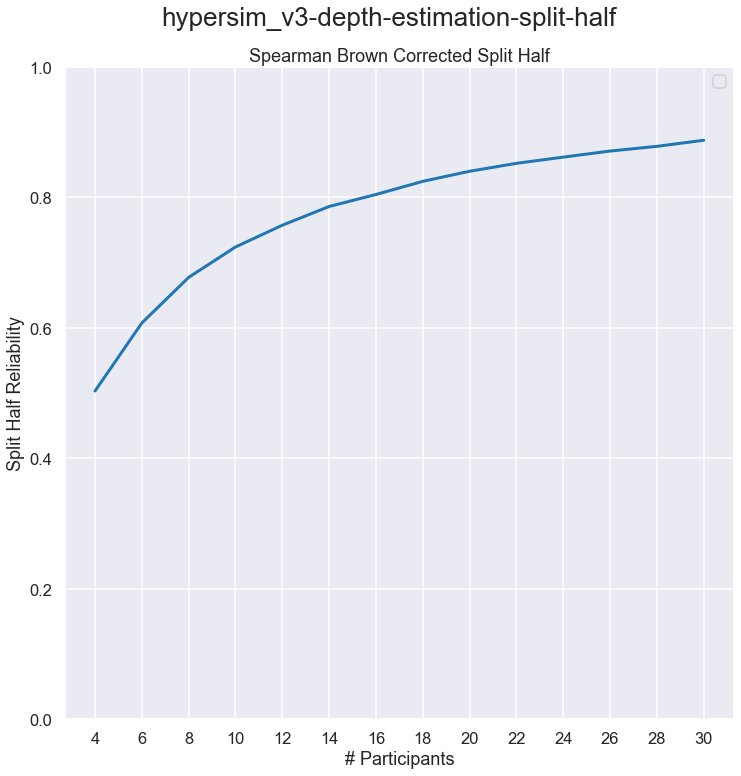




hypersim_v3-segmentation-split-half
No one failed any attention checks!


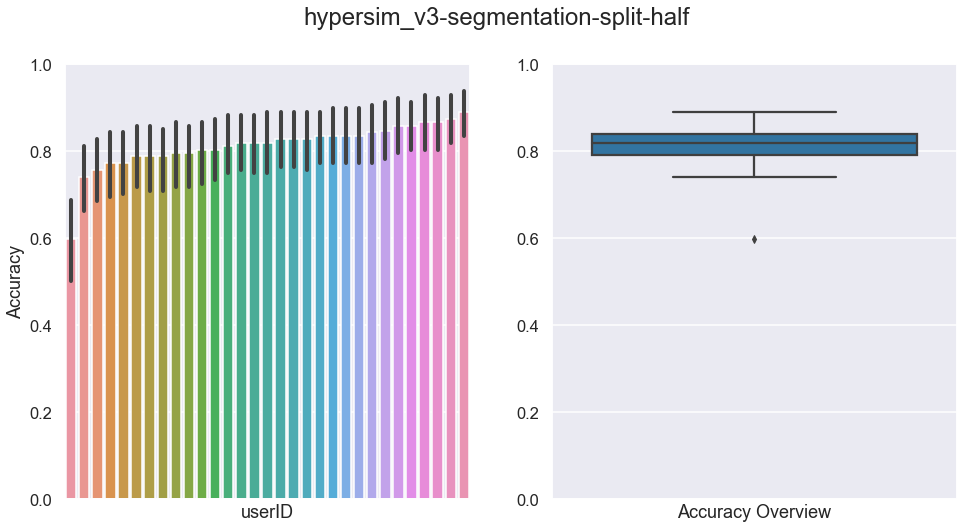

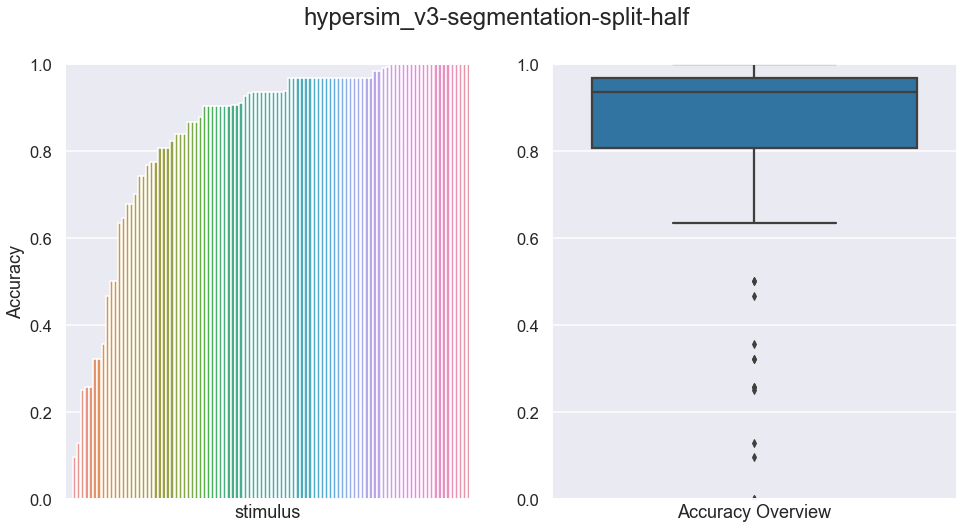

Minimum people per trial: 30
(100, 30) trials to choose from
Subs per split [ 2  3  4  5  6  7  8  9 10 11 12 13 14 15]


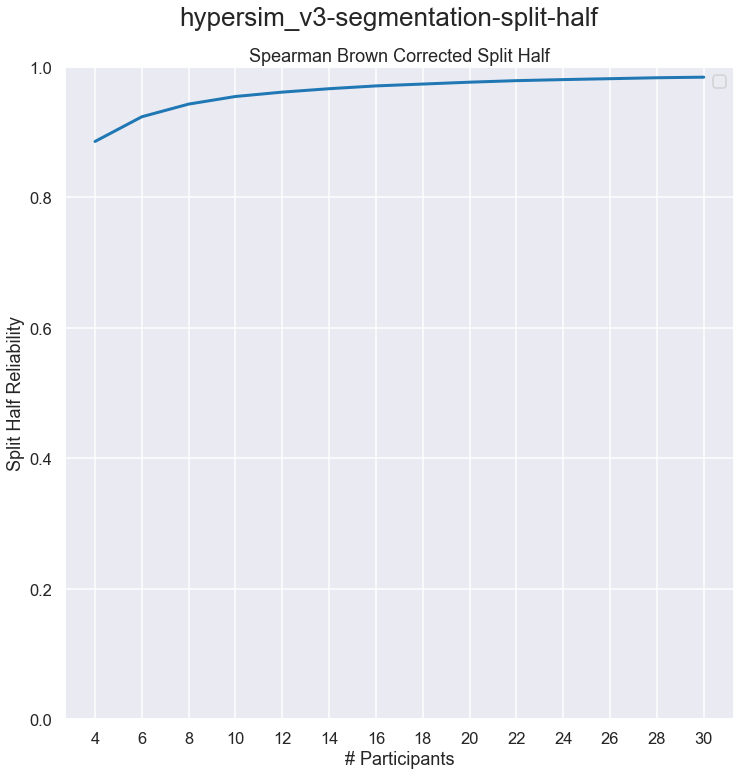




nsd-depth-estimation-pilot
nsd-segmentation


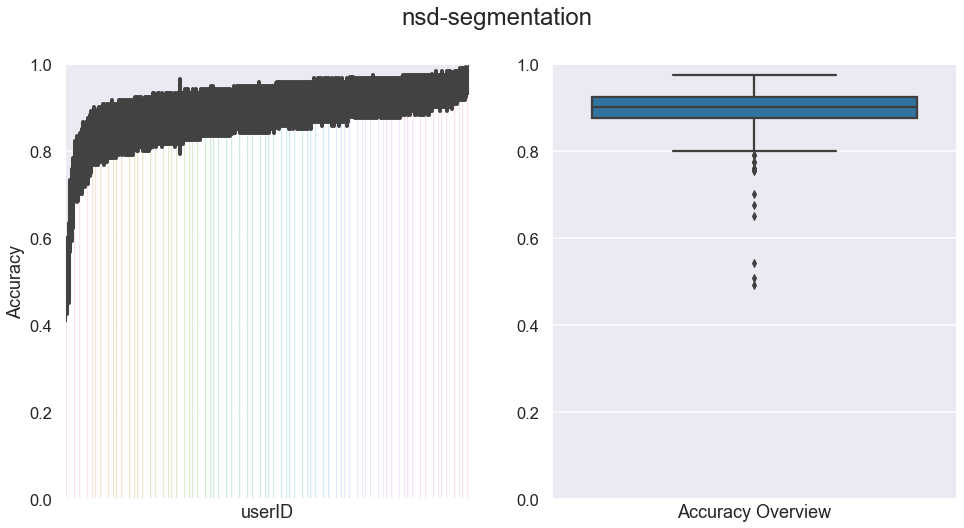

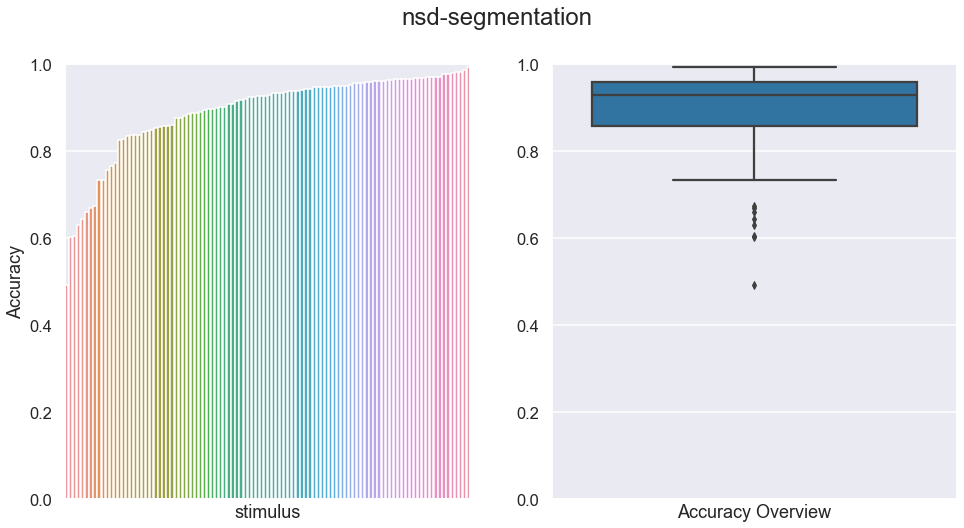

Minimum people per trial: 21
(100, 21) trials to choose from
Subs per split [ 2  3  4  5  6  7  8  9 10]


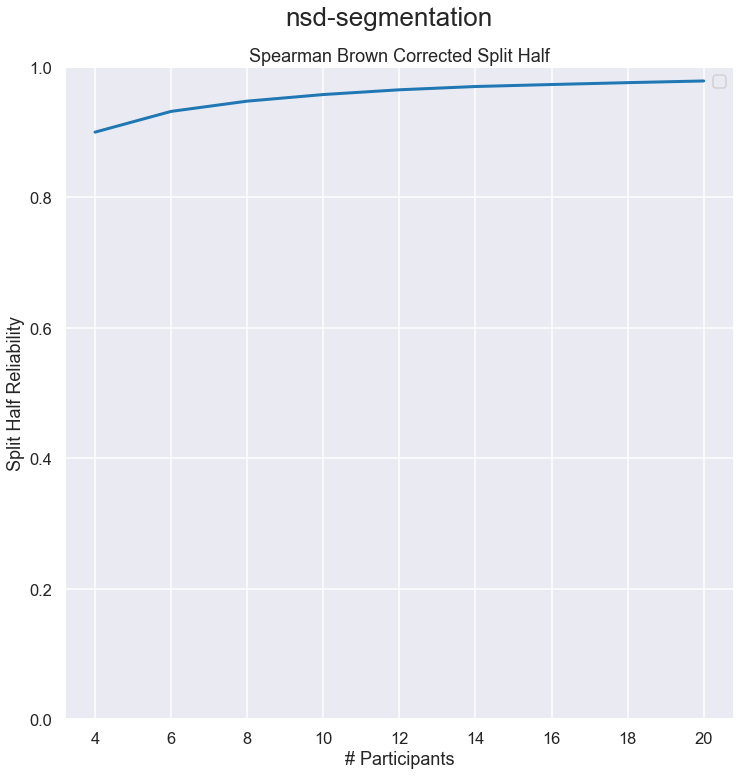




Minimum people per trial: 21
(100, 21) trials to choose from
Subs per split [ 2  3  4  5  6  7  8  9 10]


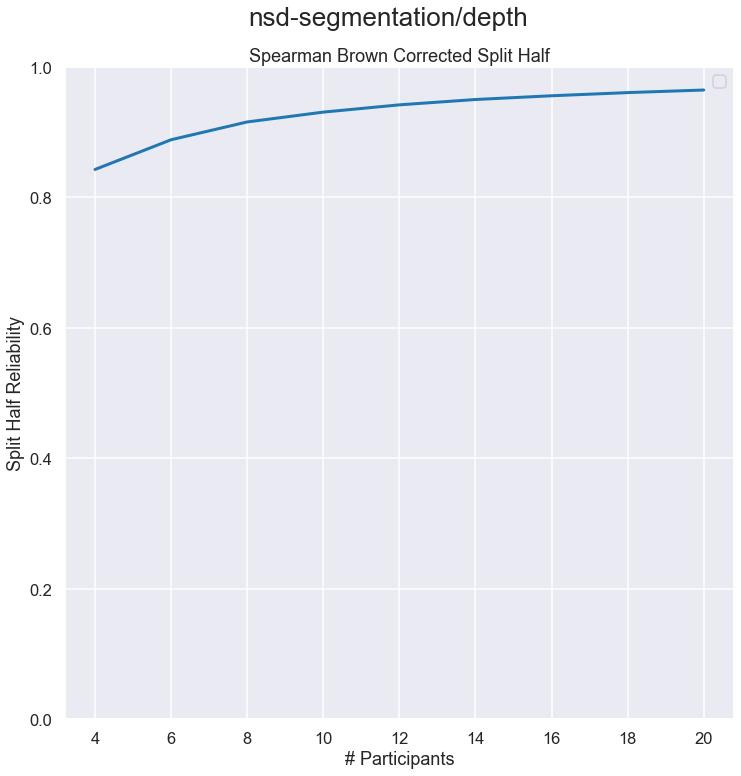

0.9817706790757873
tdw-depth-estimation-pilot


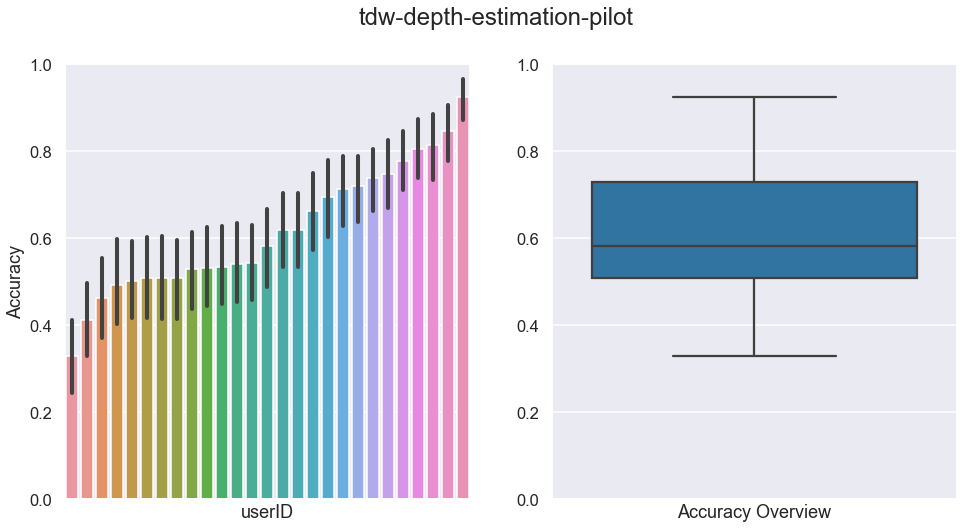

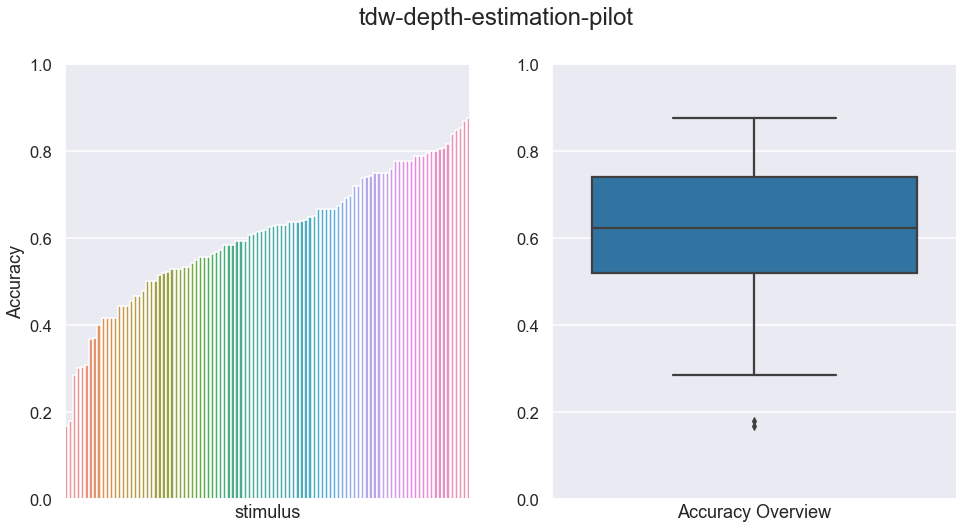

Minimum people per trial: 4
Not enough people to check split half.



tdw-depth-estimation-split-half


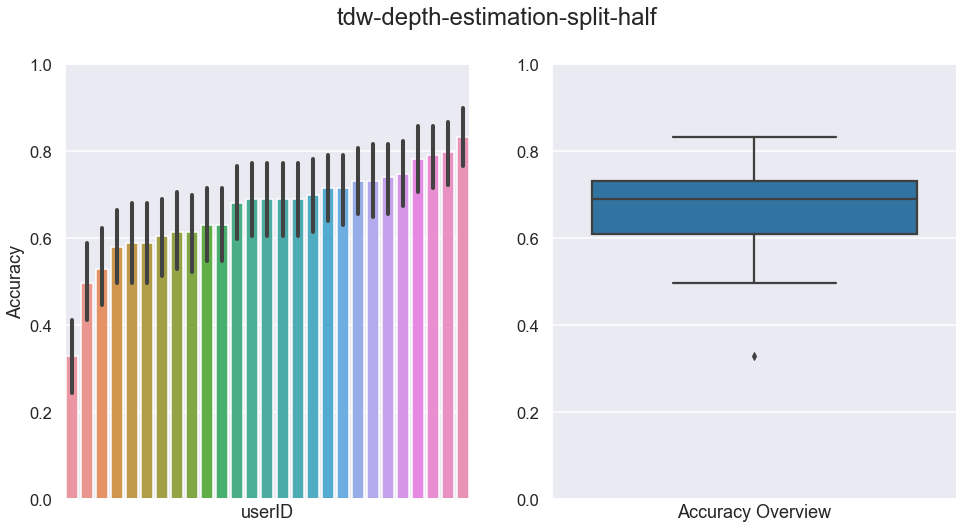

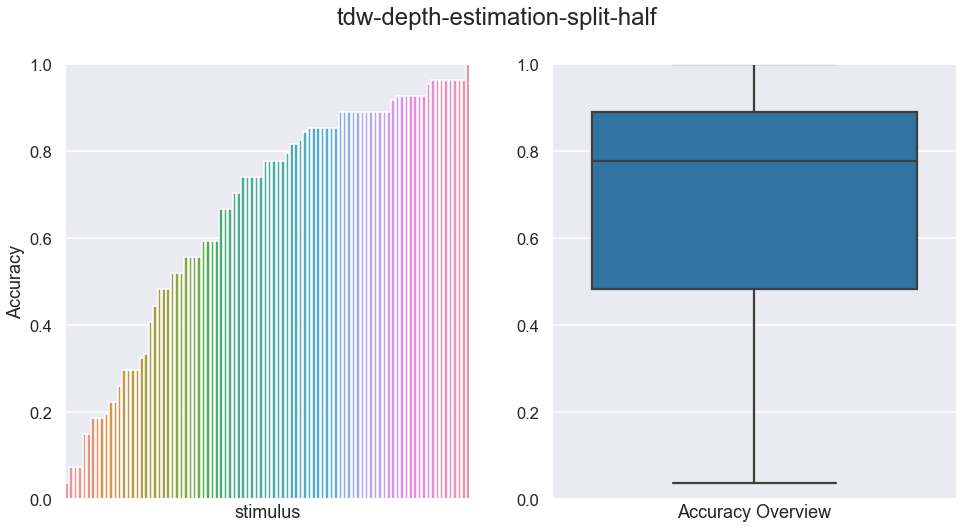

Minimum people per trial: 27
(92, 27) trials to choose from
Subs per split [ 2  3  4  5  6  7  8  9 10 11 12 13]


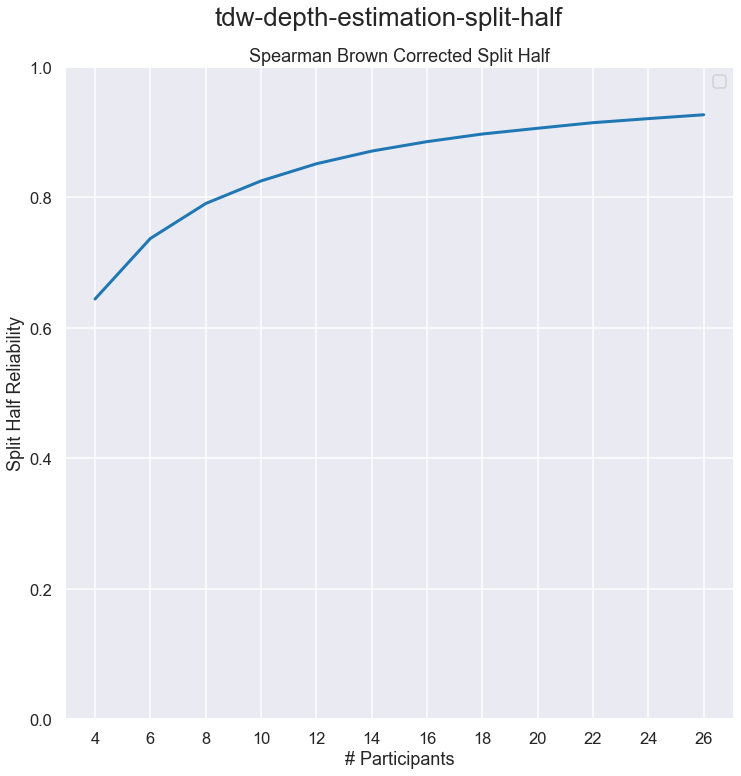




tdw-segmentation


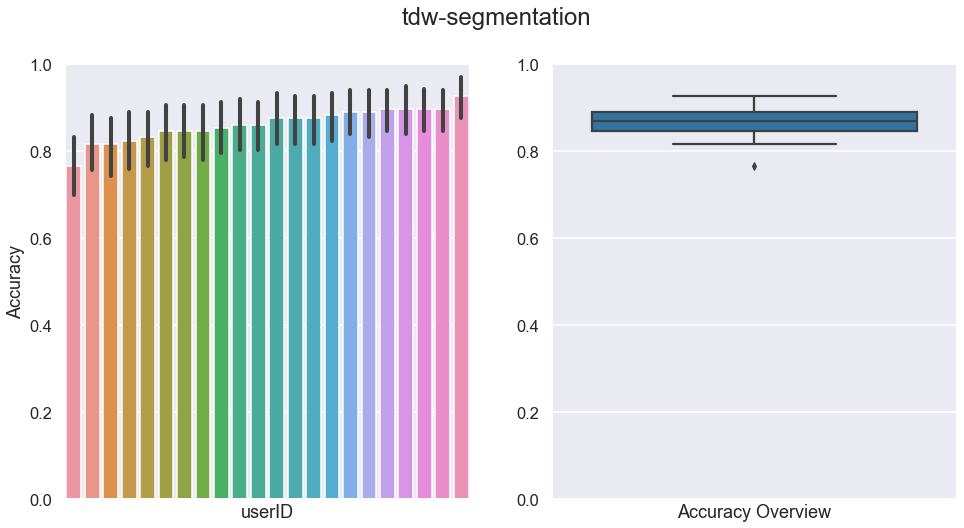

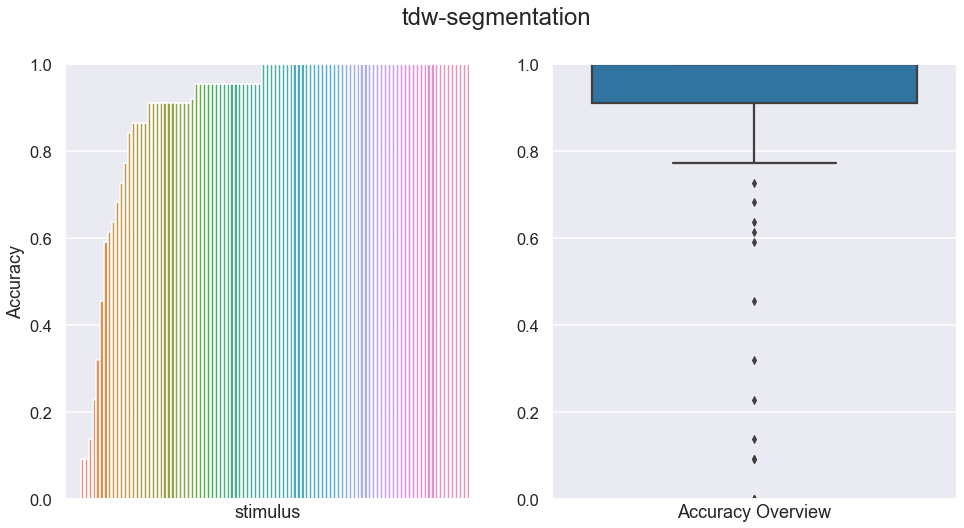

Minimum people per trial: 22
(103, 22) trials to choose from
Subs per split [ 2  3  4  5  6  7  8  9 10 11]


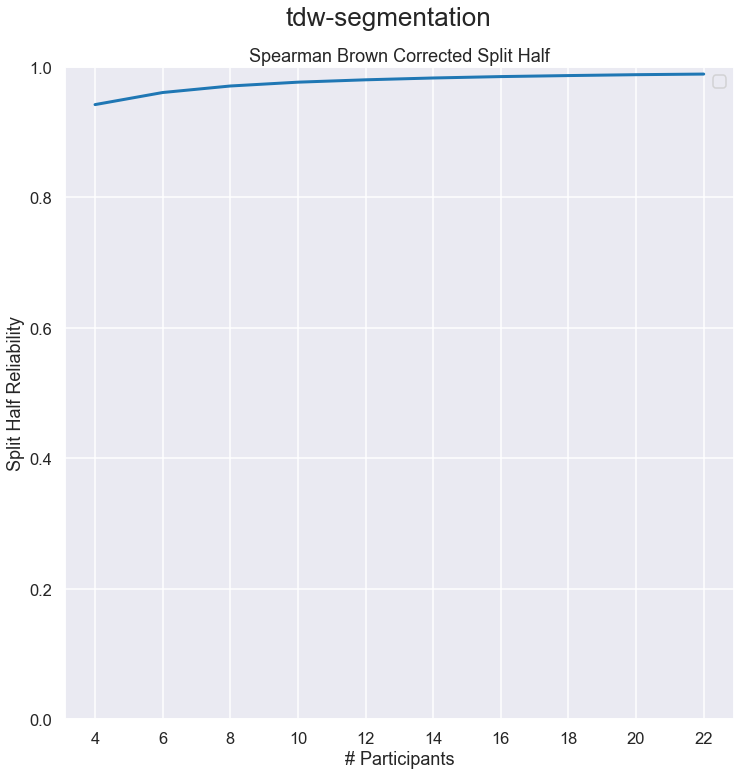




tdw-segmentation-split-half
No one failed any attention checks!


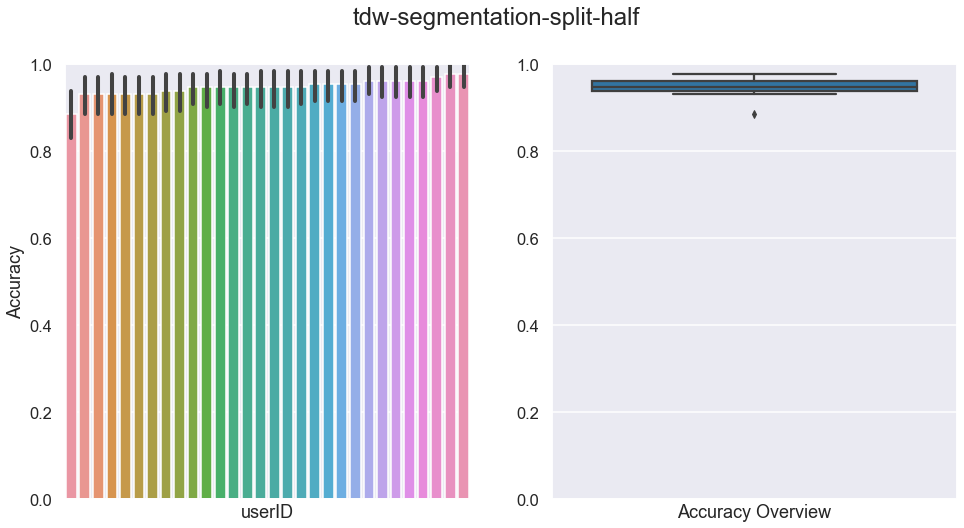

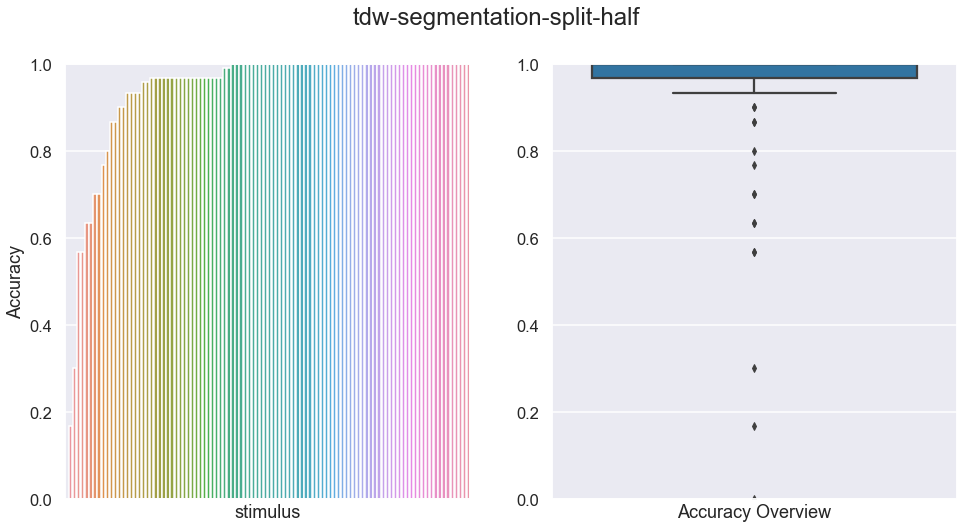

Minimum people per trial: 30
(100, 30) trials to choose from
Subs per split [ 2  3  4  5  6  7  8  9 10 11 12 13 14 15]


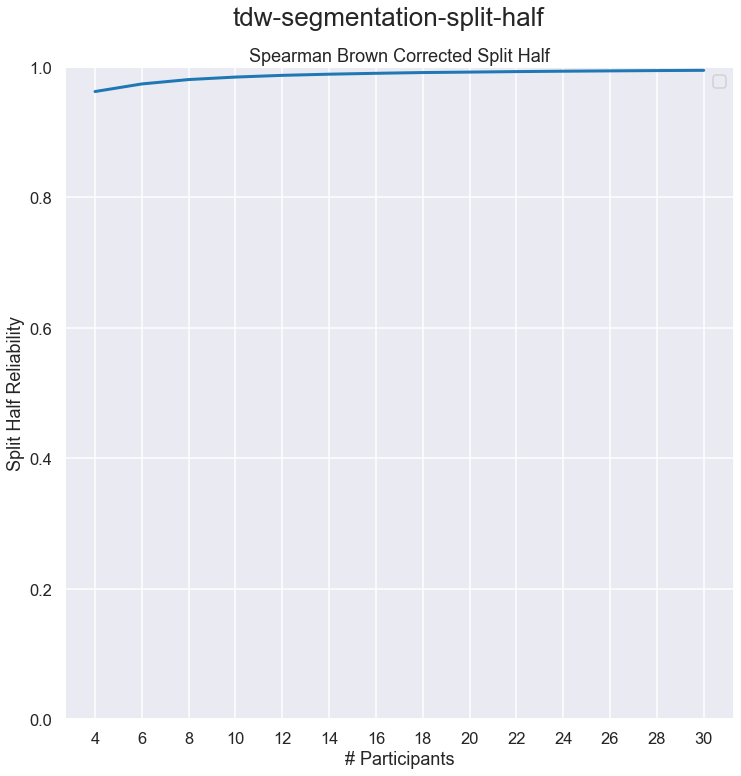

In [110]:
accuracies = {'segmentation': {}, 'depth': {}, 'normals': {}}
dsets = {'segmentation': [], 'depth': [], 'normals': []}
split_halfs = {'segmentation': {}, 'depth': {}, 'normals': {}}
nsd_joint_depth_split_half = 0

for col_name in names:
    path = f"datasets/{col_name}.csv"
    if "depth" in path or "segmentation" in path:
        
        if 'depth' in path:
            key = 'depth'
        elif 'segmentation' in path:
            key = 'segmentation'
        
        print(col_name)

        if col_name == "nsd-depth-estimation-pilot" or col_name == "nsd-depth-estimation-split-half":
            continue
            
        accuracy_key = "correct"
        target_key = "userID"
        
        if col_name == "nsd-segmentation" or col_name == "tdw-segmentation":
            accuracy_key = "segmentation_correct"
            
        
        df = pd.read_csv(path)
        if col_name != "tdw-segmentation":   # the TDW segmentation/depth task had a bug with attention checks
            df = filter_attention_check_fails(df, accuracy_key)
            
        df = df[df["trial_type"].str.contains("task")]
        if key == "depth":
            # filter out trials with "Same" as correct response
            df = df[df["correctChoice"] != 2]


        fig, mean_acc = plotting.plot_accuracy(df, col_name, accuracy_key=accuracy_key, target_key=target_key)
        plt.show()
        plt.close()
        fig = plotting.plot_accuracy(df, col_name, accuracy_key=accuracy_key, errorbar=None, target_key="stimulus")
        plt.show()
        plt.close()
        
        if df["response"].iloc[0] is np.nan:
            response_key = "segmentation_response"
        else:
            response_key = "response"
            
        df[response_key] = pd.to_numeric(df[response_key])
        
        split_half = plotting.plot_split_half(df, response_key, col_name)
        print("\n\n")
        
        if col_name == "nsd-segmentation":
            df["depth_response"] = df["depth_response"].fillna(-1)
            depth_split_half = plotting.plot_split_half(df, "depth_response", col_name + "/depth")
            nsd_joint_depth_split_half = np.max(depth_split_half)
            print(nsd_joint_depth_split_half)
            
        accuracies[key][col_name] = mean_acc
        dsets[key].append(col_name)
        split_halfs[key][col_name] = np.max(split_half)

datasets/hypersim_surface-normals.csv
Minimum people per trial: 8
(100, 8, 3) trials to choose from
Subs per split [2 3 4]


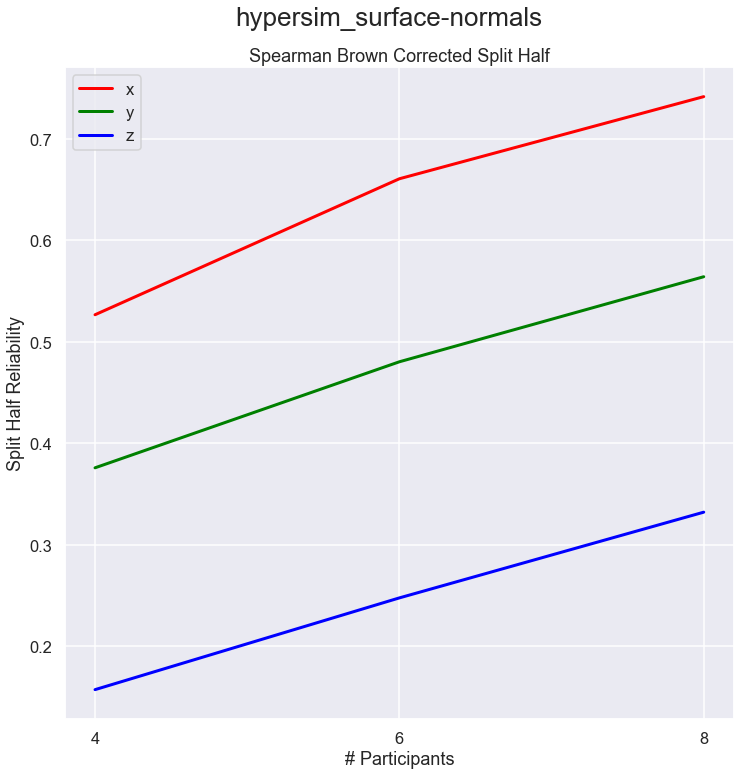

datasets/gestalt_shapegen-surface-normals.csv
Minimum people per trial: 11
(100, 11, 3) trials to choose from
Subs per split [2 3 4 5]


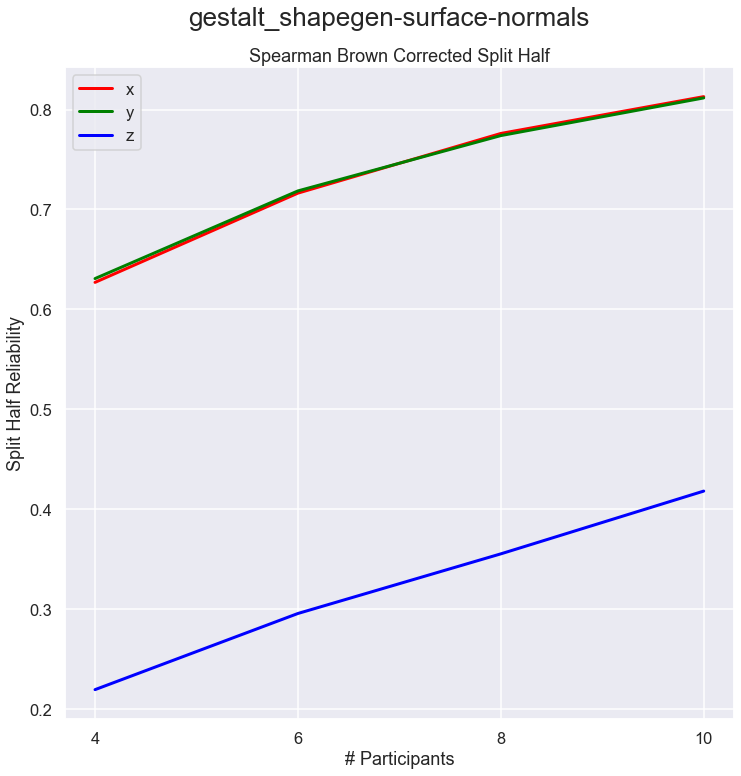

datasets/tdw_surface-normals.csv
Minimum people per trial: 6
Not enough people to check split half.
datasets/nsd_surface-normals.csv
Minimum people per trial: 4
Not enough people to check split half.
datasets/hypersim_v3-surface-normals.csv
Minimum people per trial: 10
(100, 10, 3) trials to choose from
Subs per split [2 3 4 5]


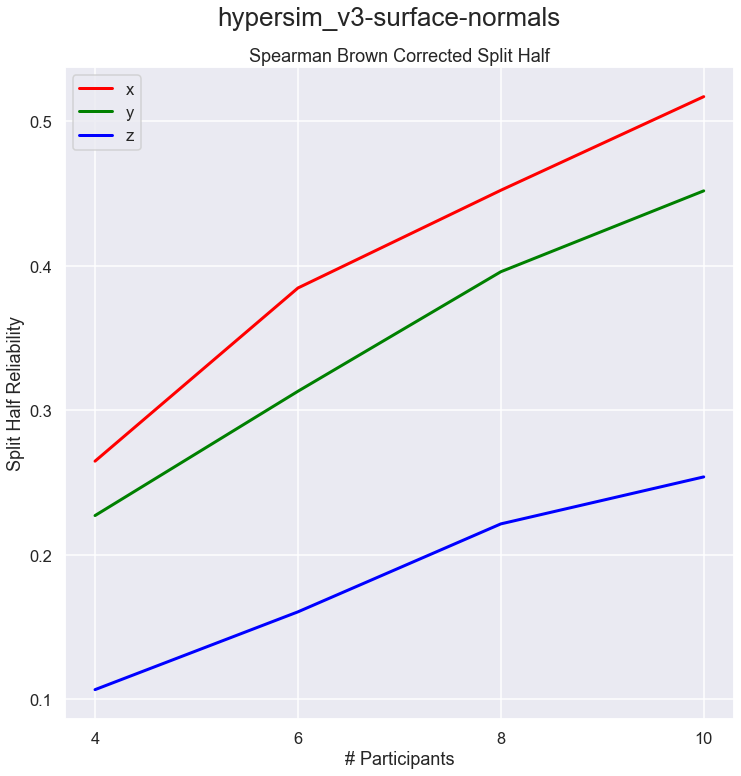

datasets/tdw-surface-normals-split-half.csv
Minimum people per trial: 29
(100, 29, 3) trials to choose from
Subs per split [ 2  3  4  5  6  7  8  9 10 11 12 13 14]


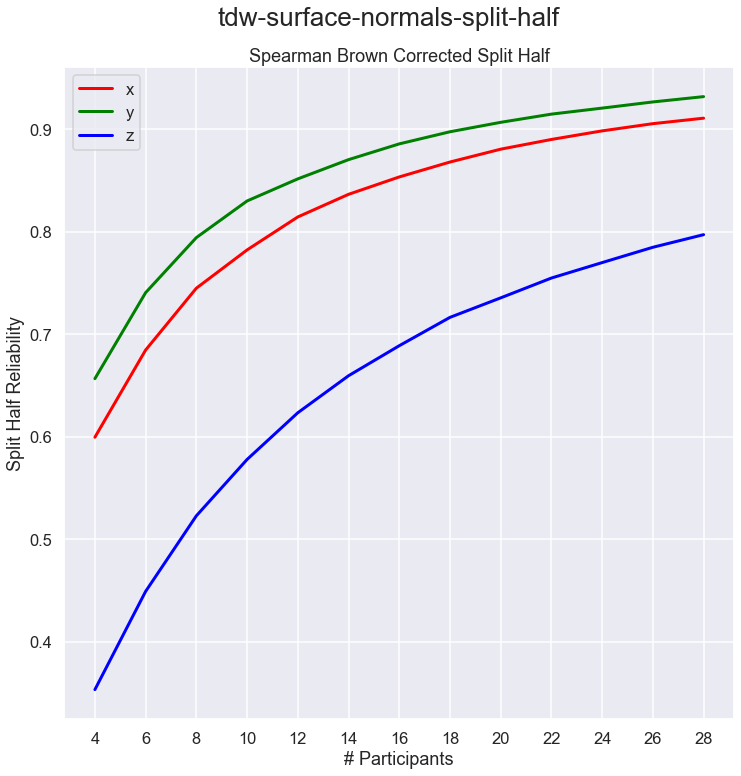

datasets/nsd-surface-normals.csv
Minimum people per trial: 12
(100, 12, 3) trials to choose from
Subs per split [2 3 4 5 6]


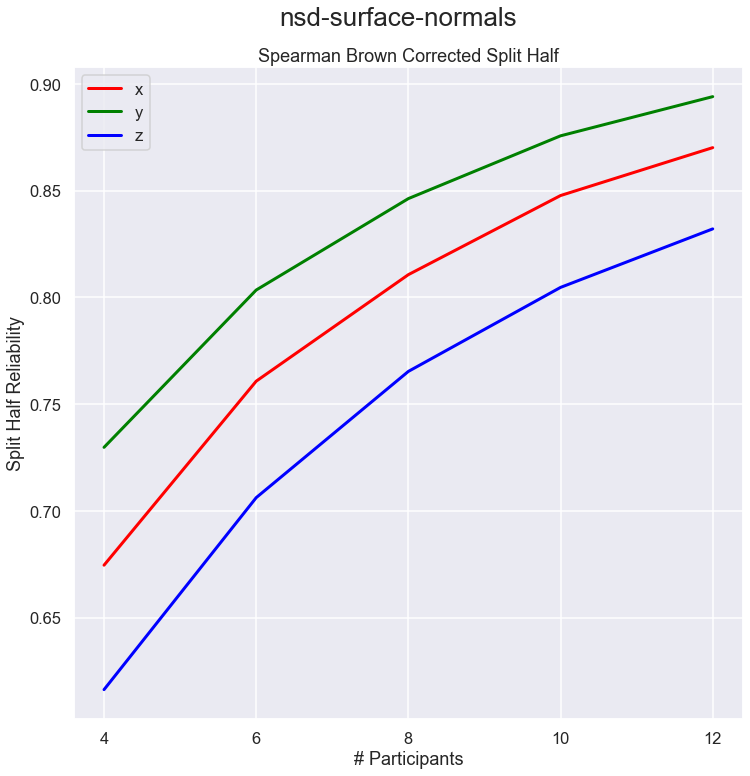

datasets/hypersim_surface-normals-splithalf.csv
Minimum people per trial: 38
(100, 38, 3) trials to choose from
Subs per split [ 2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19]


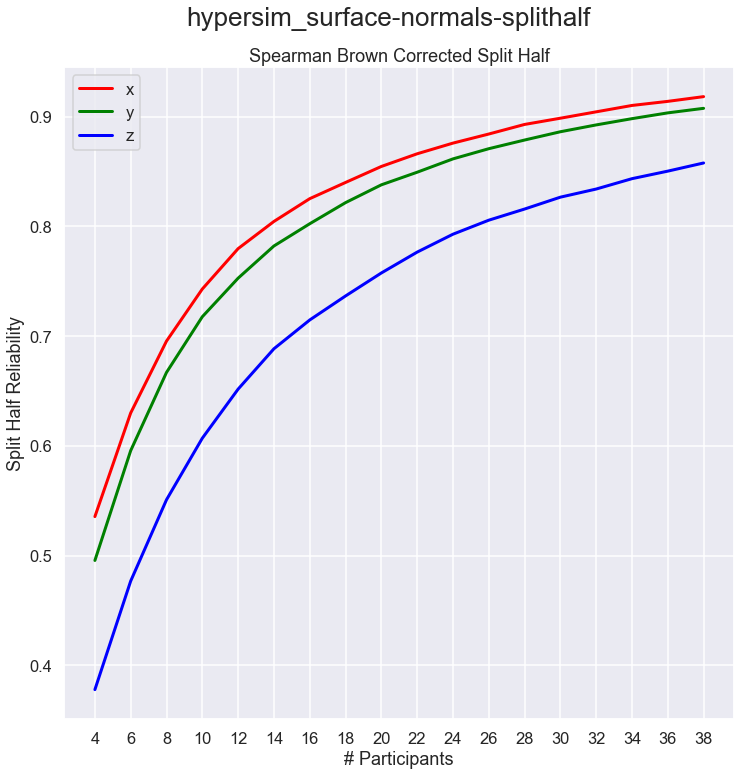

datasets/gestalt_shapegen-surface-normals-split-half.csv
Minimum people per trial: 28
(100, 28, 3) trials to choose from
Subs per split [ 2  3  4  5  6  7  8  9 10 11 12 13 14]


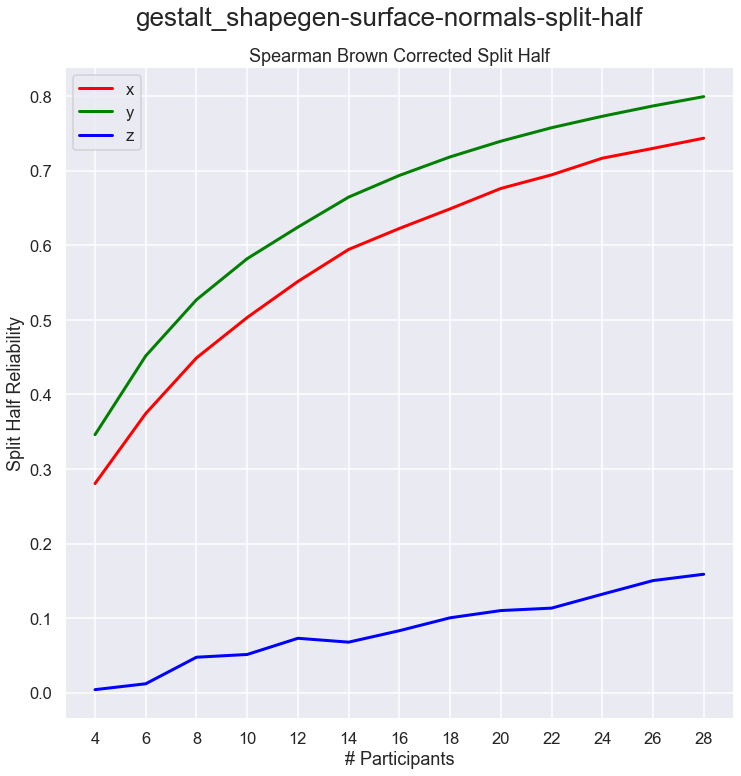

In [67]:
for col_name in names:
    path = f"datasets/{col_name}.csv"
    if "surface-normals" in path:
        # if "hypersim_surface-normals" in path:
        #     continue
        
        print(path)
        
        df = pd.read_csv(path)
        df = df.dropna(axis=0, subset="indicatorFinalDirection")
        get_attention_key = lambda x: [k for k in x if "attention" in k][0]
        attention_key = get_attention_key(df.columns)
        get_duplicate_key = lambda x: [k for k in x if "duplicate" in k][0]
        duplicate_key = get_duplicate_key(df.columns)
        
        df = df[df[duplicate_key] == False]
        df = df[df[attention_key] == False]
        
        df["indicatorFinalDirection"] = df["indicatorFinalDirection"].apply(str_to_float_array)
        if "nsd" not in col_name:
            df["trueArrowDirection"] = df["trueArrowDirection"].apply(str_to_float_array)
            
        split_half, split_half_sb = plotting.plot_surface_normal_split_half(df, col_name)
        if split_half is not None:
            split_halfs['normals'][col_name] = np.mean(np.mean(split_half_sb, axis=1)[-1])
            dsets['normals'].append(col_name)

datasets/gestalt_shapegen-surface-normals.csv


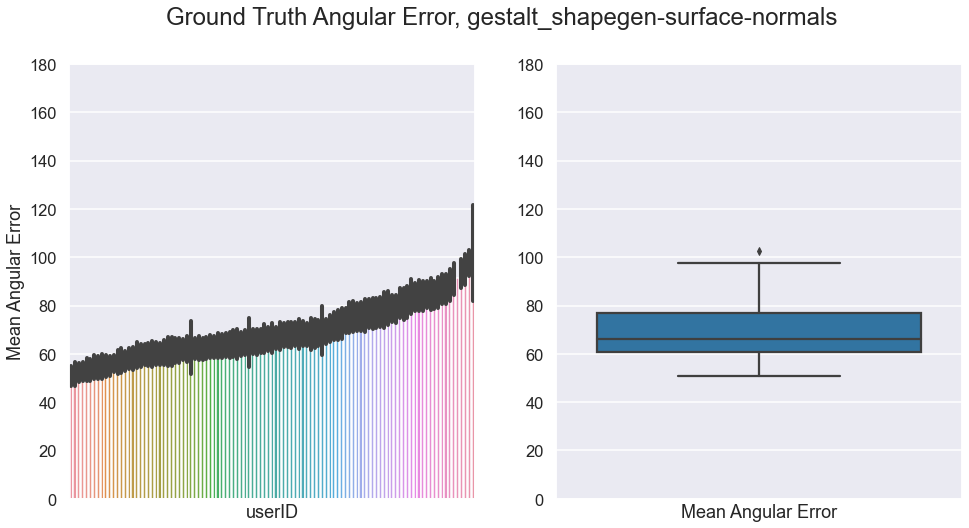

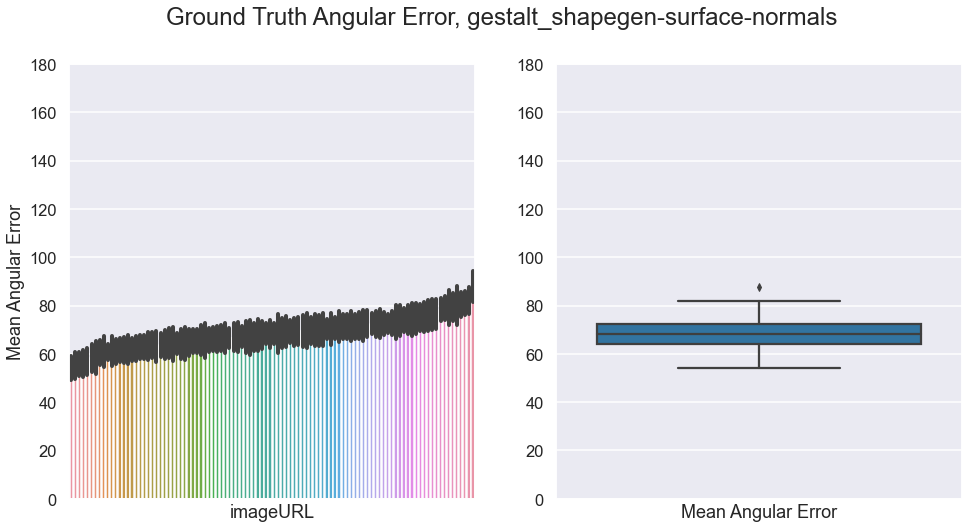

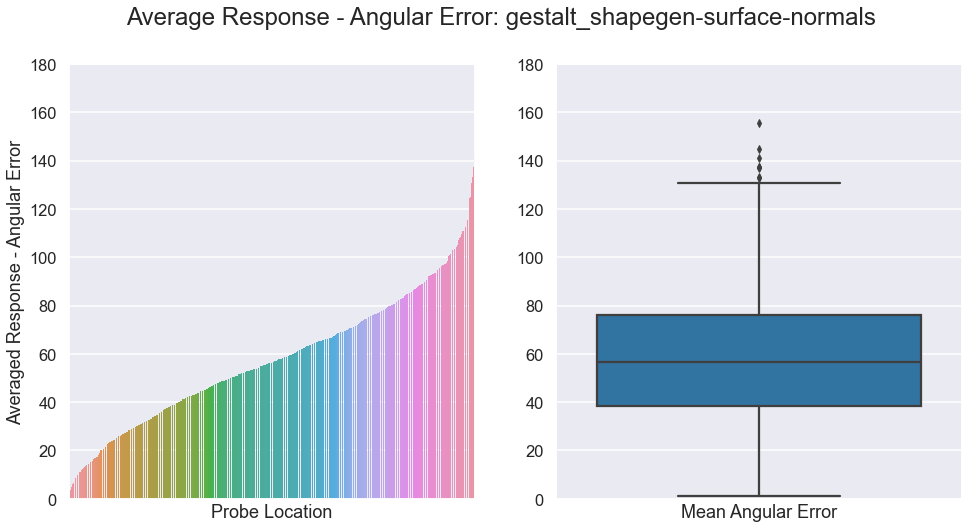

100%|██████████| 10/10 [00:05<00:00,  1.72it/s]


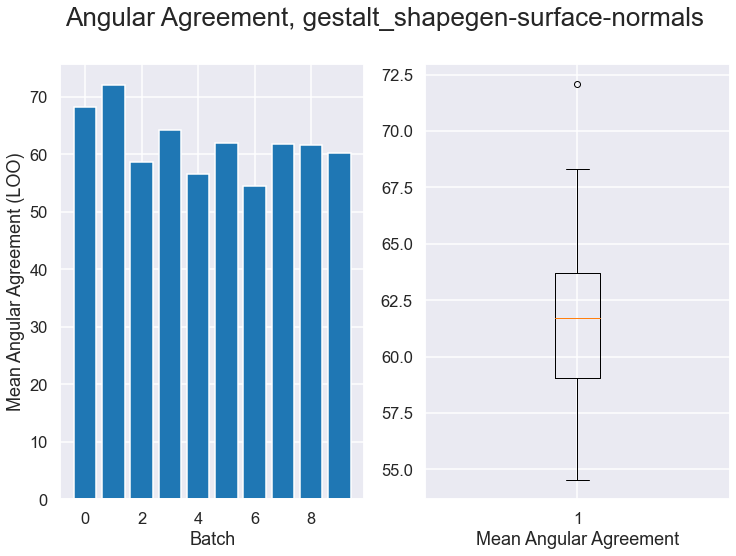

datasets/tdw_surface-normals.csv


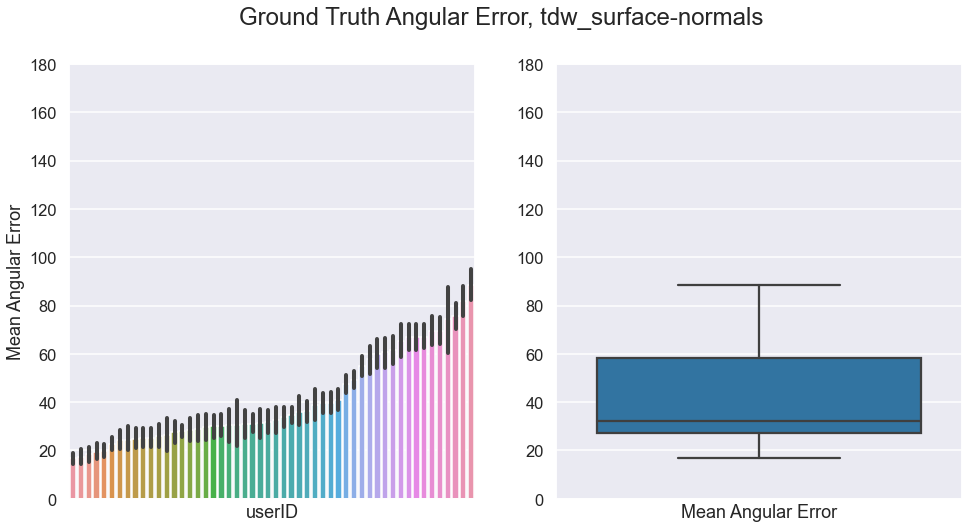

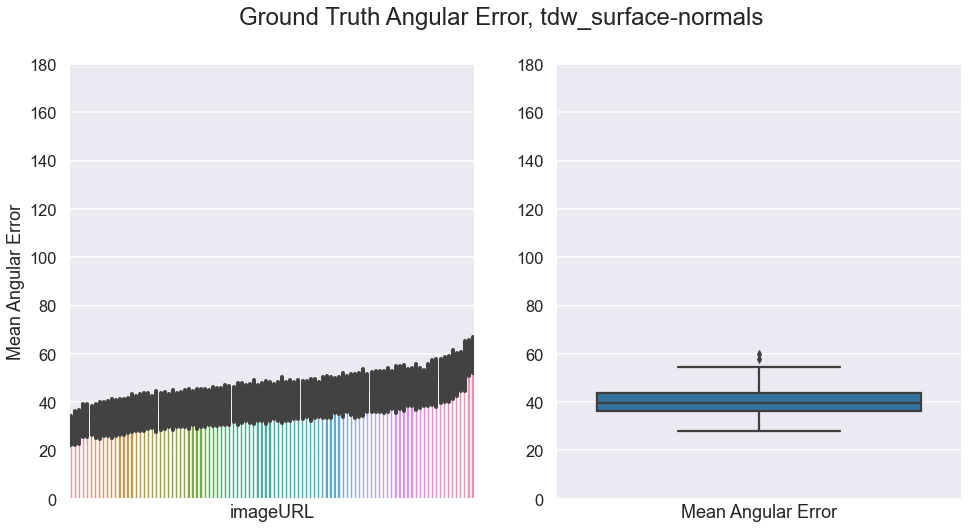

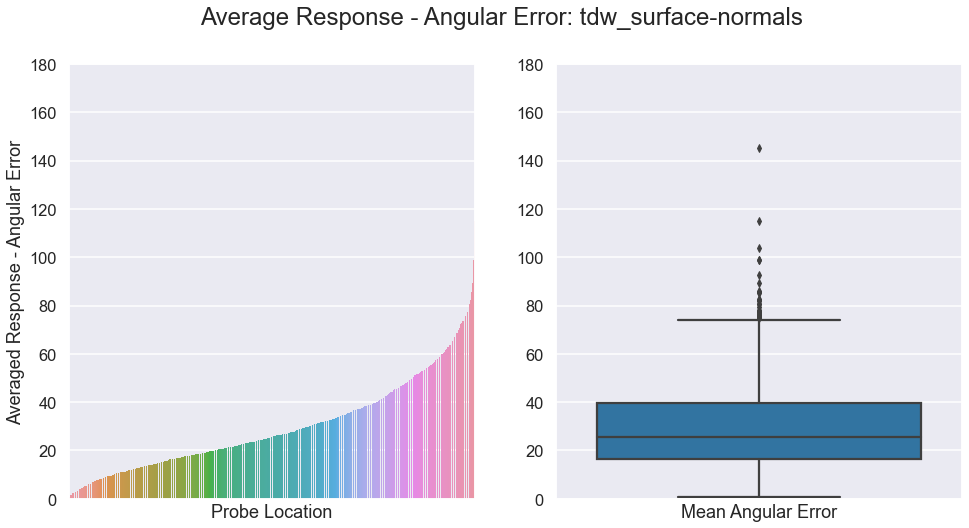

100%|██████████| 10/10 [00:01<00:00,  6.37it/s]


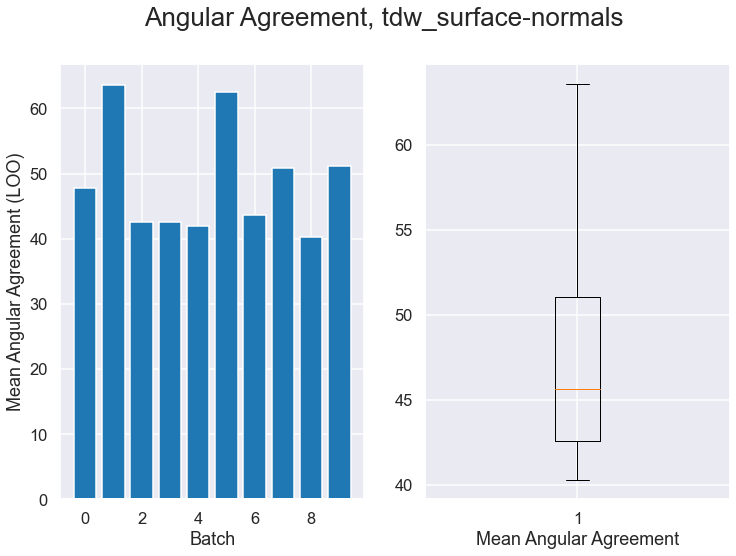

datasets/nsd_surface-normals.csv


100%|██████████| 10/10 [00:00<00:00, 14.60it/s]


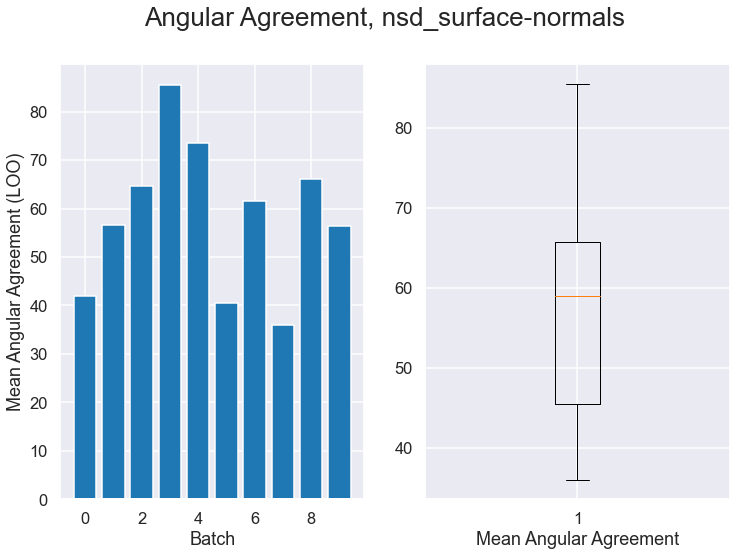

datasets/hypersim_v3-surface-normals.csv


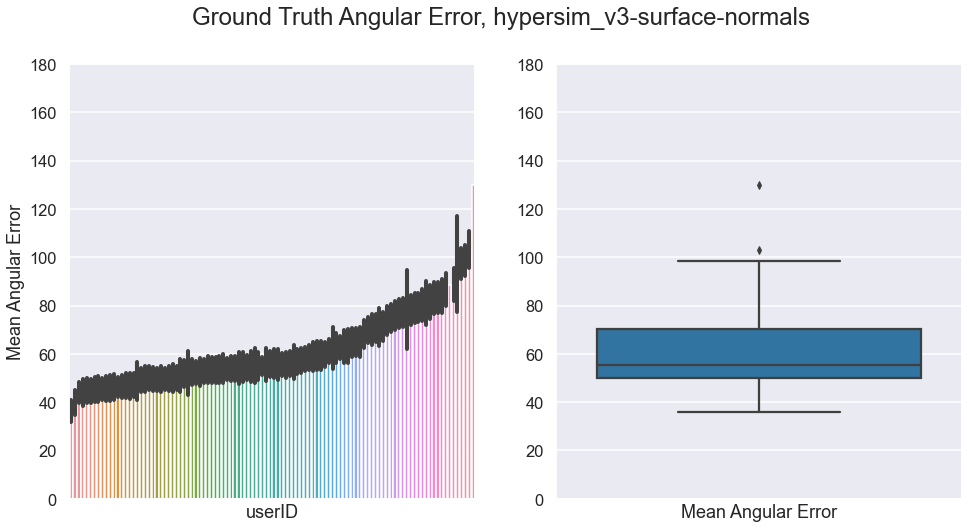

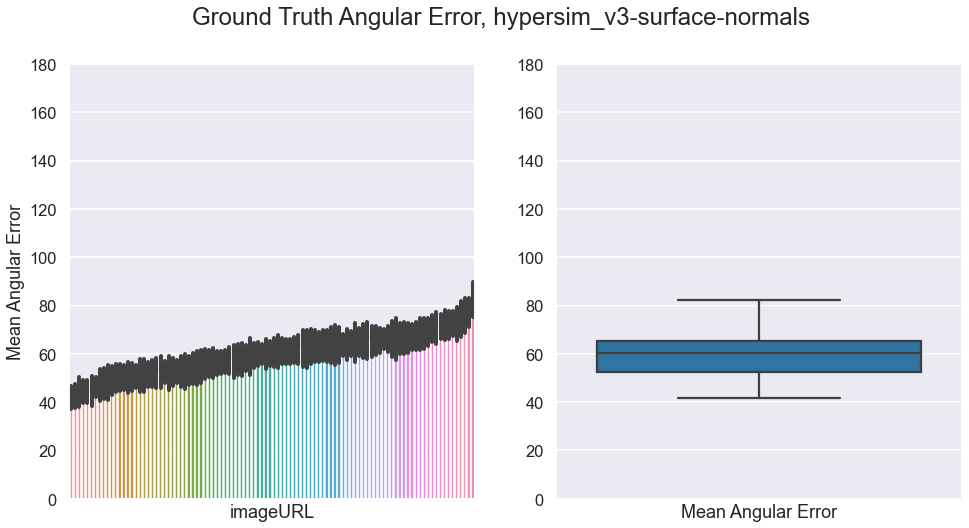

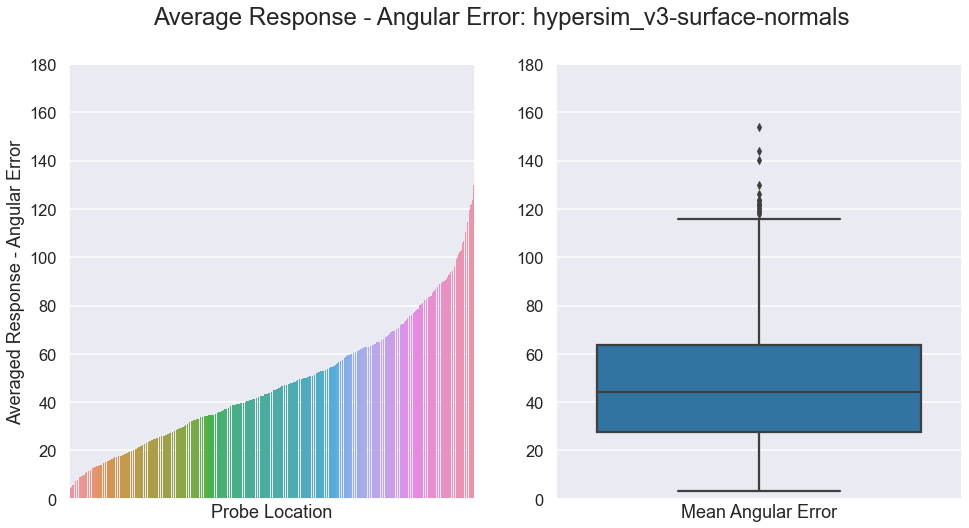

100%|██████████| 10/10 [00:05<00:00,  1.88it/s]


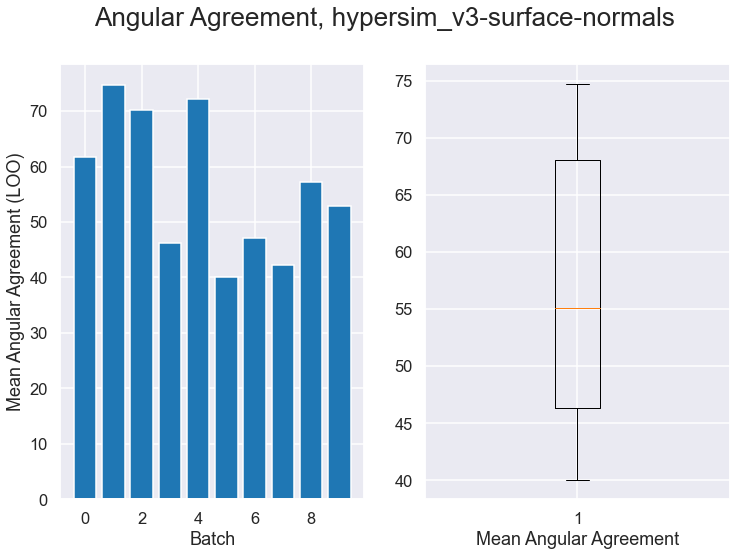

datasets/tdw-surface-normals-split-half.csv


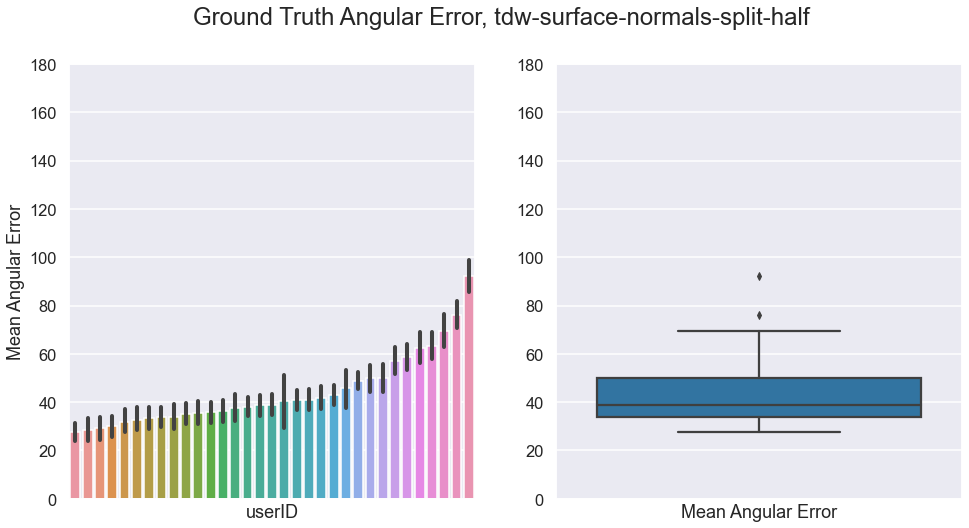

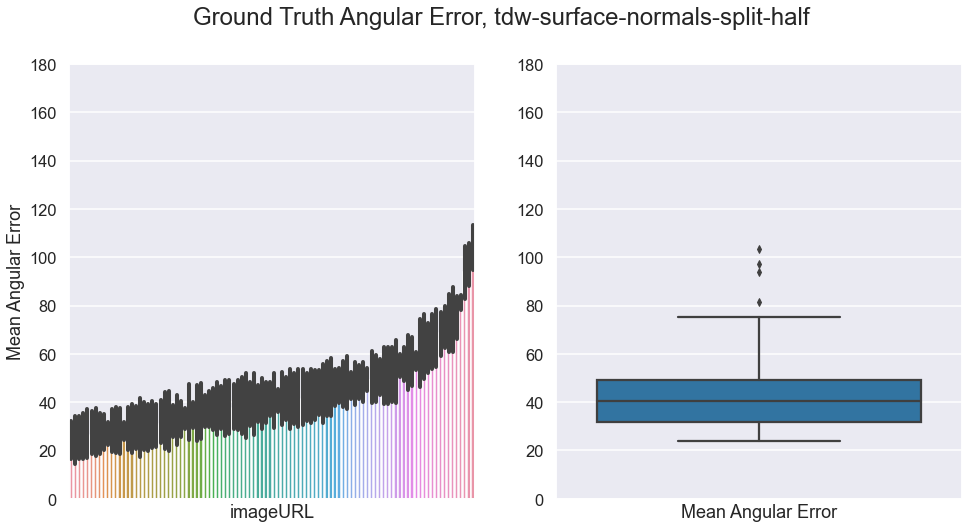

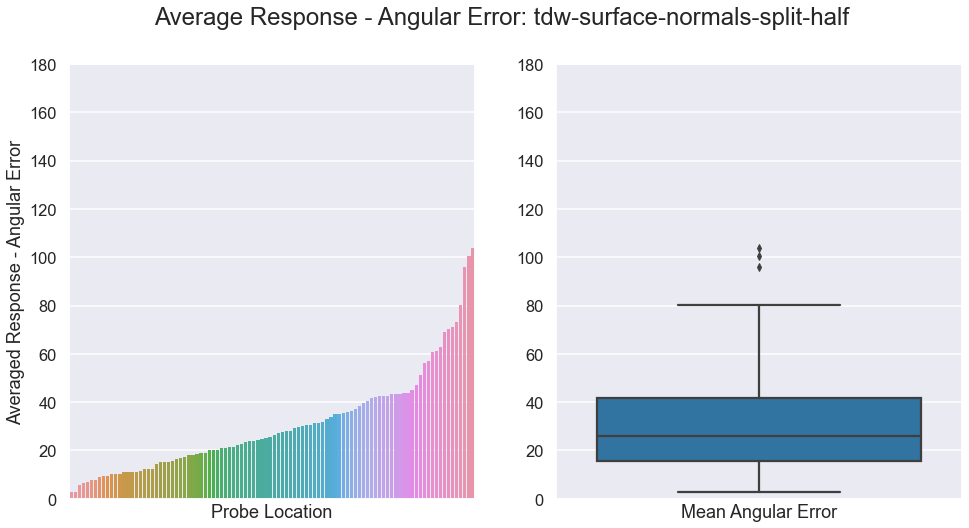

100%|██████████| 1/1 [00:05<00:00,  5.13s/it]


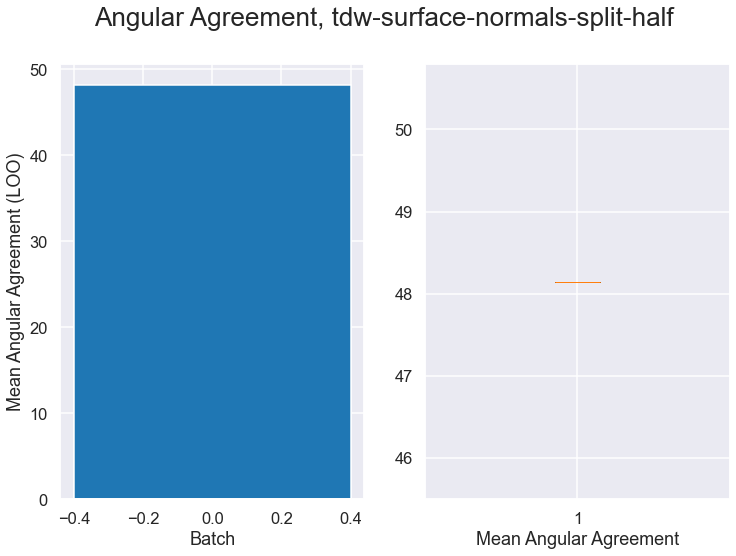

datasets/nsd-surface-normals.csv


100%|██████████| 30/30 [00:08<00:00,  3.59it/s]


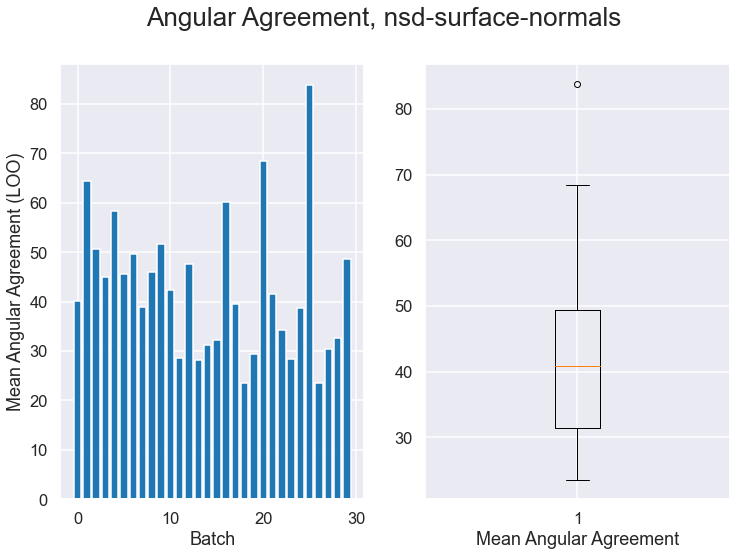

datasets/gestalt_shapegen-surface-normals-split-half.csv


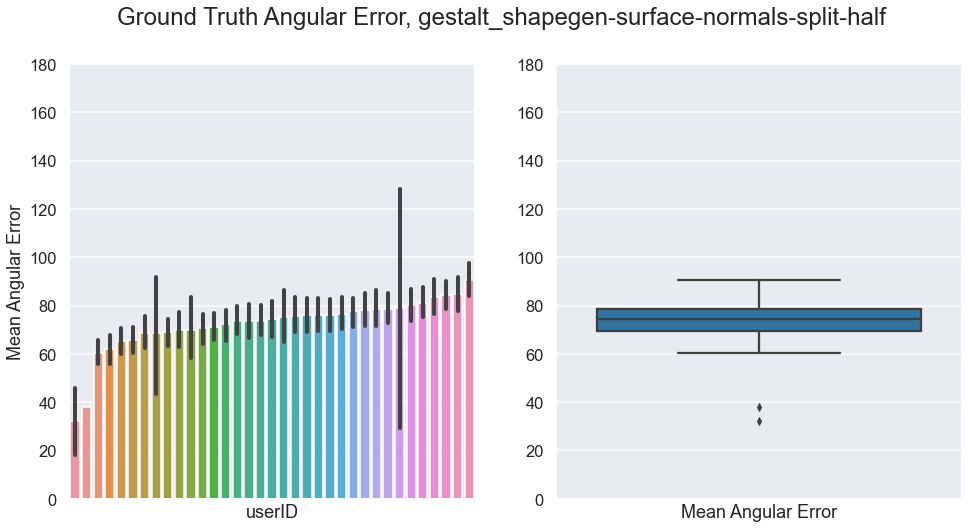

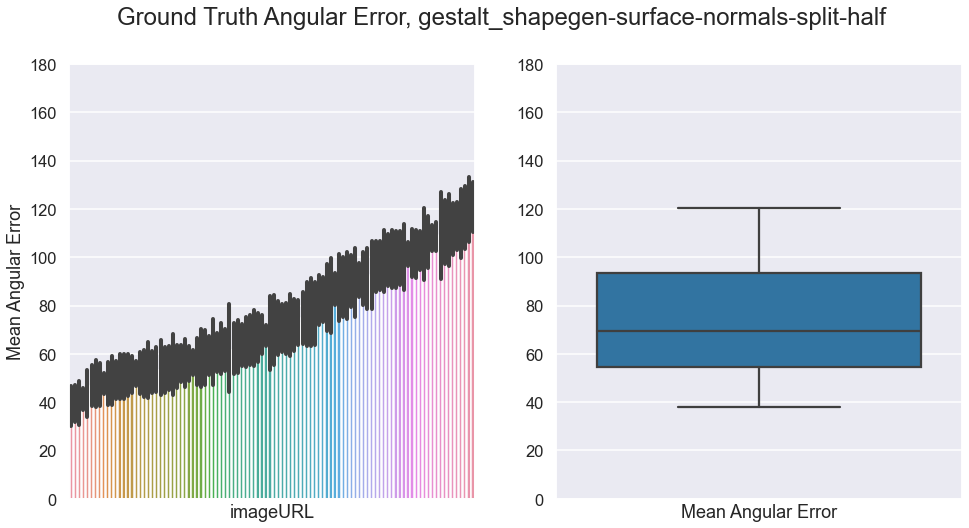

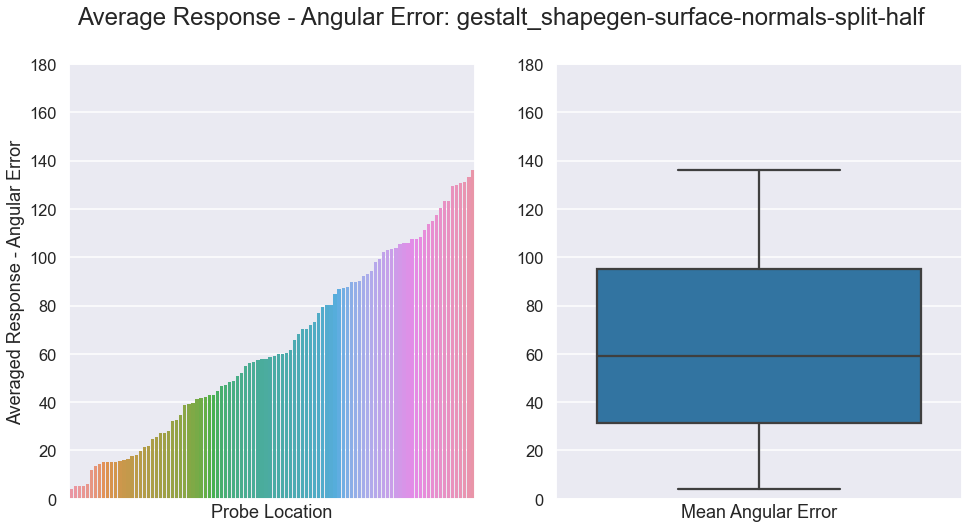

100%|██████████| 1/1 [00:04<00:00,  4.72s/it]


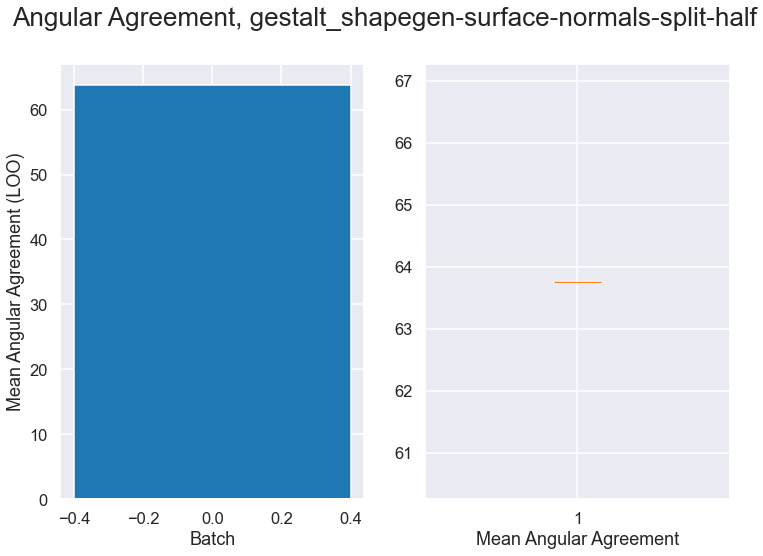

In [68]:
for col_name in names:
    path = f"datasets/{col_name}.csv"
    if "surface-normals" in path:
        if "hypersim_surface-normals" in path:
            continue
        
        print(path)
        
        df = pd.read_csv(path)
        df = df.dropna(axis=0, subset="indicatorFinalDirection")
        get_attention_key = lambda x: [k for k in x if "attention" in k][0]
        attention_key = get_attention_key(df.columns)
        get_duplicate_key = lambda x: [k for k in x if "duplicate" in k][0]
        duplicate_key = get_duplicate_key(df.columns)

        df = df[df[duplicate_key] == False]
        df = df[df[attention_key] == False]
        
        df["indicatorFinalDirection"] = df["indicatorFinalDirection"].apply(str_to_float_array)
        if "nsd" not in col_name:
            df["trueArrowDirection"] = df["trueArrowDirection"].apply(str_to_float_array)
            fig, mean_ae = plotting.plot_mean_angular_error(df, "Ground Truth Angular Error, " + col_name, "userID")
            plt.show()
            plt.close()
            plotting.plot_mean_angular_error(df, "Ground Truth Angular Error, " + col_name, "imageURL")
            plt.show()
            plt.close()
            fig, avg_error = plotting.plot_average_response_angular_error(df, "Average Response - Angular Error: " +col_name)
            plt.show()
            plt.close()
            
        plotting.plot_mean_angular_agreement(df, "Angular Agreement, " + col_name)
        plt.show()
        plt.close()
        if col_name in dsets["normals"]:
            accuracies['normals'][col_name] = mean_ae

In [69]:
accuracies

{'segmentation': {'tdw-segmentation-split-half': 0.9469230769230766,
  'gestalt_shapegen-segmentation-split-half': 0.6958847604008894,
  'tdw-segmentation': 0.8619652406417113,
  'nsd-segmentation': 0.8903382128275836,
  'hypersim_v3-segmentation-split-half': 0.8124184157919233},
 'depth': {'tdw-depth-estimation-pilot': 0.6166648778177178,
  'hypersim_v2-depth-estimation-pilot': 0.651091304115399,
  'tdw-depth-estimation-split-half': 0.6635543106131342,
  'gestalt_shapegen-depth-estimation-pilot': 0.5275471428968568,
  'hypersim_v3-depth-estimation-split-half': 0.5749354005167959,
  'gestalt_shapegen-depth-estimation-split-half': 0.4340876944837341},
 'normals': {'gestalt_shapegen-surface-normals': 69.01528127286511,
  'hypersim_v3-surface-normals': 61.10528704483023,
  'tdw-surface-normals-split-half': 44.18412925505365,
  'nsd-surface-normals': 44.18412925505365,
  'gestalt_shapegen-surface-normals-split-half': 72.32945446956953}}

In [70]:
split_halfs

{'segmentation': {'tdw-segmentation-split-half': 0.9979186831876746,
  'gestalt_shapegen-segmentation-split-half': 0.9619975162396023,
  'tdw-segmentation': 0.9947541331046452,
  'nsd-segmentation': 0.9901479626709948,
  'hypersim_v3-segmentation-split-half': 0.9926384067294817},
 'depth': {'tdw-depth-estimation-pilot': None,
  'hypersim_v2-depth-estimation-pilot': None,
  'tdw-depth-estimation-split-half': 0.9584414370760445,
  'gestalt_shapegen-depth-estimation-pilot': None,
  'hypersim_v3-depth-estimation-split-half': 0.9331799176111002,
  'gestalt_shapegen-depth-estimation-split-half': 0.809031420774341},
 'normals': {'hypersim_surface-normals': 0.5460124371503489,
  'gestalt_shapegen-surface-normals': 0.6808267598028263,
  'hypersim_v3-surface-normals': 0.40765693637125705,
  'tdw-surface-normals-split-half': 0.8796995261901793,
  'nsd-surface-normals': 0.8654149641134853,
  'hypersim_surface-normals-splithalf': 0.8944404610572615,
  'gestalt_shapegen-surface-normals-split-half': 

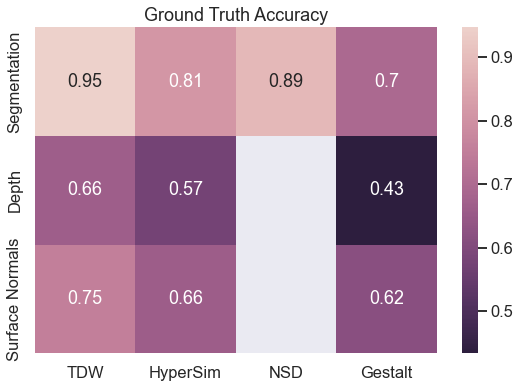

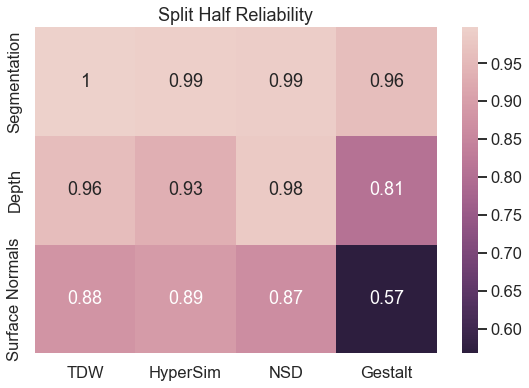

In [90]:
def ae_score(x):
    return 1-(x/180)

dset_keys = ['tdw', 'hyper', 'nsd', 'gestalt']
tasks = ['segment', 'depth', 'normals']

acc_mat = [[accuracies['segmentation']["tdw-segmentation-split-half"],
            accuracies['segmentation']["hypersim_v3-segmentation-split-half"], 
            accuracies['segmentation']["nsd-segmentation"],
            accuracies['segmentation']["gestalt_shapegen-segmentation-split-half"]],
           
           [accuracies['depth']["tdw-depth-estimation-split-half"], 
            accuracies['depth']["hypersim_v3-depth-estimation-split-half"], 
            np.nan,
            accuracies['depth']["gestalt_shapegen-depth-estimation-split-half"]],
           
           [ae_score(accuracies['normals']["tdw-surface-normals-split-half"]), 
            ae_score(accuracies['normals']["hypersim_v3-surface-normals"]), 
            np.nan,
            ae_score(accuracies['normals']["gestalt_shapegen-surface-normals"])]]



sh_mat = [[split_halfs['segmentation']["tdw-segmentation-split-half"], 
           split_halfs['segmentation']["hypersim_v3-segmentation-split-half"], 
           split_halfs['segmentation']["nsd-segmentation"],
           split_halfs['segmentation']["gestalt_shapegen-segmentation-split-half"]],
          
           [split_halfs['depth']["tdw-depth-estimation-split-half"], 
            split_halfs['depth']["hypersim_v3-depth-estimation-split-half"], 
            nsd_joint_depth_split_half,
            split_halfs['depth']["gestalt_shapegen-depth-estimation-split-half"]],
          
           [split_halfs['normals']["tdw-surface-normals-split-half"], 
            split_halfs['normals']["hypersim_surface-normals-splithalf"], 
            split_halfs['normals']["nsd-surface-normals"],
            split_halfs['normals']["gestalt_shapegen-surface-normals-split-half"]]]

#color_palette = sns.color_palette("ch:s=-.2,r=.6", as_cmap=True, reverse=True)
color_palette = sns.cubehelix_palette(as_cmap=True, reverse=True)
tasks = ["Segmentation", "Depth", "Surface Normals"]
fig = plt.figure(figsize=(9,6))
sns.heatmap(acc_mat, cmap=color_palette, annot=True)
plt.xticks(np.arange(len(dset_keys))+.5, ["TDW", "HyperSim", "NSD", "Gestalt"])
plt.yticks(np.arange(len(tasks))+.5, tasks)
plt.title("Ground Truth Accuracy")
plt.show()

fig = plt.figure(figsize=(9,6))
sns.heatmap(sh_mat, cmap=color_palette, annot=True)
plt.xticks(np.arange(len(dset_keys))+.5, ["TDW", "HyperSim", "NSD", "Gestalt"])
plt.yticks(np.arange(len(tasks))+.5, tasks)
plt.title("Split Half Reliability")
plt.show()

([<matplotlib.axis.YTick at 0x2826d0f70>,
 [Text(0, 0.5, 'Response-Averaged'), Text(0, 1.5, 'Mean Accuracy')])

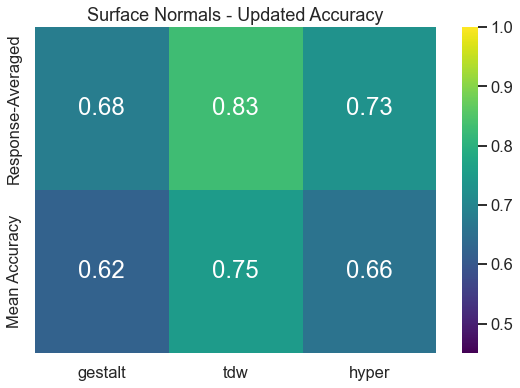

In [34]:
fig = plt.figure(figsize=(9, 6))
results = [[0.68,	0.83,	0.73], [0.62,	0.75,	0.66]]
sns.heatmap(results, vmin=0.45, vmax=1, cmap="viridis", annot=True, annot_kws={"fontsize": 24})
plt.title("Surface Normals - Updated Accuracy")
plt.xticks(np.arange(3)+.5, ["gestalt", "tdw", "hyper"])
plt.yticks(np.arange(2)+.5, ["Response-Averaged", "Mean Accuracy"])